## Análisis de severidad en señales de farmacovigilancia

La farmacovigilancia basada en bases de datos espontáneas constituye una
herramienta fundamental para la detección temprana de señales de
seguridad asociadas al uso de medicamentos en condiciones reales de
práctica clínica. Sin embargo, la heterogeneidad de los reportes, la
presencia de confusión por indicación y la fuerte asimetría en la
distribución de frecuencias plantean retos sustanciales para la
interpretación de los resultados, particularmente cuando se analizan
eventos adversos clasificados como graves.

En este contexto, los métodos de desproporcionalidad —como el Reporting
Odds Ratio (ROR) y el Proportional Reporting Ratio (PRR)— permiten
identificar asociaciones fármaco–evento que ocurren con mayor frecuencia
de la esperada bajo un supuesto de independencia. No obstante, estos
indicadores pueden verse influidos tanto por el volumen de exposición
(número de informes) como por la severidad clínica de los desenlaces, lo
que hace necesario complementar el análisis con métricas descriptivas
que capturen la carga y el perfil de gravedad de las señales.

En este estudio analizamos las señales clínicas reportadas, estratificadas
por categoría de severidad (`Severe` vs `Moderate/Mild`), con el objetivo
de caracterizar simultáneamente (i) la frecuencia de las asociaciones
fármaco–evento, (ii) la distribución de métricas de desproporcionalidad y
(iii) la proporción relativa de eventos graves por fármaco y por tipo de
reacción adversa. A partir de esta caracterización, proponemos un esquema
exploratorio de **priorización de candidatos**, definido por la
combinación de una carga suficiente de reportes y una fracción elevada de
eventos severos.

Es importante enfatizar que el propósito de este análisis es
exploratorio y descriptivo. La identificación de señales o candidatos no
implica una relación causal directa, sino que busca orientar análisis
posteriores más detallados, incluyendo estratificación clínica, ajuste
por factores de confusión y evaluación experta, con el fin de apoyar la
toma de decisiones en farmacovigilancia.


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

Construimos el dataset combinado de pares (D,A) para 2025-Q1 a 2025-Q4 y guardamos en .csv

Deduplicaremos dentro de cada reporte (por safetyreportid) para que cada reporte cuente como una sola evidencia de que un fármaco $D$ y una reacción $A$ aparecen juntos, evitando inflar artificialmente los conteos.

En FAERS es común que, dentro del mismo reporte, un mismo fármaco o reacción aparezca repetido (por múltiples entradas, dosis, formulaciones, roles del medicamento, o registros duplicados).

In [80]:
# Cargamos los 4 trimestres
BASE_ROOT = Path("data_processed")
quarters = ["q1_2025_sample100k", "q2_2025_sample100k", "q3_2025_sample100k", "q4_2025_sample100k"]

all_pairs = []

for q in quarters:
    base = BASE_ROOT / q

    reports = pd.read_csv(base/f"{q.split('_')[0]}_reports_100k.csv", dtype={"safetyreportid":"string"})
    drugs = pd.read_csv(base/f"{q.split('_')[0]}_drugs_100k.csv", dtype={"safetyreportid":"string"})
    reactions = pd.read_csv(base/f"{q.split('_')[0]}_reactions_100k.csv", dtype={"safetyreportid":"string"})

    # Limpieza 
    for col in ["medicinalproduct", "activesubstancename"]:
        drugs[col] = drugs[col].astype("string").str.strip().str.upper()
    reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

    # D principal: sustancia activa 
    drugs["drug_key"] = drugs["activesubstancename"].fillna(drugs["medicinalproduct"]).astype("string")
    drugs["drug_key"] = drugs["drug_key"].str.strip().str.upper()

    # Deduplicar dentro de cada reporte
    drugs_u = drugs[["safetyreportid","drug_key"]].dropna().drop_duplicates()
    reac_u  = reactions[["safetyreportid","reaction_pt"]].dropna().drop_duplicates()

    # Pares por trimestre
    pairs = drugs_u.merge(reac_u, on="safetyreportid", how="inner")
    pairs["quarter"] = q.split("_")[0].upper()  

    # Guardar pares del trimestre
    pairs.to_csv(base/f"{q.split('_')[0]}_pairs_100k.csv", index=False)

    all_pairs.append(pairs)

# Unimos los 3 trimestres
pairs_2025_q1q4 = pd.concat(all_pairs, ignore_index=True)
out_path = BASE_ROOT / "pairs_2025_q1q4_400k.csv"
pairs_2025_q1q4.to_csv(out_path, index=False)

print("Saved combined pairs:", out_path)
print("rows:", len(pairs_2025_q1q4))
print("unique drugs:", pairs_2025_q1q4["drug_key"].nunique())
print("unique reactions:", pairs_2025_q1q4["reaction_pt"].nunique())
print("quarters counts:\n", pairs_2025_q1q4["quarter"].value_counts())


Saved combined pairs: data_processed/pairs_2025_q1q4_400k.csv
rows: 10954199
unique drugs: 25107
unique reactions: 13099
quarters counts:
 quarter
Q3    2878325
Q4    2872625
Q1    2837090
Q2    2366159
Name: count, dtype: int64


In [81]:
df = pairs_2025_q1q4.copy()

#  Universo GLOBAL de informes
N = df["safetyreportid"].nunique()

# deduplicar a nivel de informe
df4 = df.drop_duplicates(["safetyreportid","drug_key","reaction_pt"])
dfD = df.drop_duplicates(["safetyreportid","drug_key"])
dfA = df.drop_duplicates(["safetyreportid","reaction_pt"])


# Conteos básicos:
# n11: # reportes donde aparece (D,A)
n11 = (df4.groupby(["drug_key","reaction_pt"])
          .size()
          .rename("n11")
          .reset_index())

# n1.: # reportes donde aparece D (cualquier A)
n1dot = (dfD.groupby("drug_key")
           .size()
           .rename("n1dot")
           .reset_index())

# n.1: # reportes donde aparece A (cualquier D)
ndot1 = (dfA.groupby("reaction_pt")
           .size()
           .rename("ndot1")
           .reset_index())


# Creamos tabla 2x2 por par

sig = (n11.merge(n1dot, on="drug_key", how="left")
          .merge(ndot1, on="reaction_pt", how="left"))

sig["N"] = int(N)
sig["n10"] = sig["n1dot"] - sig["n11"] # D sin A
sig["n01"] = sig["ndot1"] - sig["n11"] # A sin D
sig["n00"] = sig["N"] - sig["n11"] - sig["n10"] - sig["n01"] # ni D ni A


#  filtro mínimo de soporte
MIN_N11 = 5
sig = sig[sig["n11"] >= MIN_N11].copy()

# ROR + IC95% (con corrección 0.5 tipo Haldane-Anscombe para evitar division by zero)
a = sig["n11"].astype(float) + 0.5
b = sig["n10"].astype(float) + 0.5
c = sig["n01"].astype(float) + 0.5
d = sig["n00"].astype(float) + 0.5

sig["ROR"] = (a*d)/(b*c)
sig["SE_logROR"] = np.sqrt(1/a + 1/b + 1/c + 1/d)
sig["ROR_L95"] = np.exp(np.log(sig["ROR"]) - 1.96*sig["SE_logROR"])
sig["ROR_U95"] = np.exp(np.log(sig["ROR"]) + 1.96*sig["SE_logROR"])

# PRR (solo para comparar)
sig["PRR"] = (sig["n11"] / (sig["n11"] + sig["n10"])) / (sig["n01"] / (sig["n01"] + sig["n00"]))

# Ranking para prioriza los pares con ROR_L95 > 1 y luego ROR
sig["is_signal"] = sig["ROR_L95"] > 1
sig = sig.sort_values(["is_signal","ROR"], ascending=[False, False])

print("N reports:", N)
print("signals rows:", len(sig))
sig

N reports: 390140
signals rows: 294554


,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
1217743,PENFLURIDOL,PAROXYSMAL PERCEPTUAL ALTERATION,6,6,7,390140,0,1,390133,3.381157e+06,1.679439,125747.104223,9.091440e+07,390134.000000,True
1273130,PREDNAZOLINE,BRAIN SCAN ABNORMAL,7,7,9,390140,0,2,390131,2.340789e+06,1.591646,103401.331982,5.299055e+07,195066.500000,True
1217742,PENFLURIDOL,OSCILLOPSIA,6,6,8,390140,0,2,390132,2.028689e+06,1.598077,88492.249985,4.650779e+07,195067.000000,True
1481637,THERABREATH,VERTEBRAL LATERAL RECESS STENOSIS,5,5,7,390140,0,2,390133,1.716587e+06,1.606805,73608.218392,4.003184e+07,195067.500000,True
1273131,PREDNAZOLINE,CEREBRAL ARTERY THROMBOSIS,7,7,10,390140,0,3,390130,1.671988e+06,1.555330,79306.691250,3.524978e+07,130044.333333,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564300,DUPILUMAB,DEVICE DELIVERY SYSTEM ISSUE,9,34807,2474,390140,34798,2465,352868,3.907248e-02,0.325116,0.020660,7.389502e-02,0.037273,False
1496528,TIRZEPATIDE,TOXICITY TO VARIOUS AGENTS,5,15911,3472,390140,15906,3467,370762,3.697153e-02,0.426816,0.016016,8.534552e-02,0.033920,False
564308,DUPILUMAB,DEVICE LEAKAGE,7,34807,2160,390140,34800,2153,353180,3.534497e-02,0.365827,0.017256,7.239785e-02,0.033191,False
564355,DUPILUMAB,DRUG INTERACTION,7,34807,2577,390140,34800,2570,352763,2.957616e-02,0.365724,0.014442,6.056926e-02,0.027806,False


Para reducir y presentar un resultado global, nos quedamos con un ranking interpretable de señales y guardamos un archivo “final” para trabajar (Top-N + filtros estándar).

Para esto haremos lo siguiente:

- filtrar señales “positivas” (IC95% inferior > 1),

- aplicar un umbral más estricto de soporte (n11),



- guardar CSVs.

In [83]:
out_dir = Path("data_processed")
out_dir.mkdir(parents=True, exist_ok=True)

# Solo señales positivas (IC95% inferior > 1)
sig_pos = sig[sig["ROR_L95"] > 1].copy()

# Umbral de soporte más estricto 
MIN_N11_STRICT = 10
sig_pos = sig_pos[sig_pos["n11"] >= MIN_N11_STRICT].copy()

# Ranking final (por ROR o por ROR_L95)
sig_pos = sig_pos.sort_values(["ROR_L95","ROR","n11"], ascending=[False, False, False])

In [84]:
sig_pos

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
420592,COPPER,FOREIGN BODY IN REPRODUCTIVE TRACT,561,887,562,390140,326,1,389252,4.462793e+05,0.819459,89550.741919,2.224049e+06,246190.454340,True
1376995,SALICYLAMIDE,CREATININE RENAL CLEARANCE INCREASED,11,11,18,390140,0,7,390122,1.196376e+06,1.490065,64490.984152,2.219403e+07,55732.714286,True
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,24,27,36,390140,3,12,390101,2.184568e+05,0.637600,62608.018724,7.622568e+05,28897.259259,True
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,181,253,188,390140,72,7,389880,1.301394e+05,0.390690,60512.746868,2.798794e+05,39847.287973,True
1265897,POTASSIUM SORBATE,CREATININE RENAL CLEARANCE INCREASED,10,10,18,390140,0,8,390122,9.638321e+05,1.487578,52209.505418,1.779316e+07,48766.250000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353360,RITUXIMAB,TRANSAMINASES INCREASED,11,6500,388,390140,6489,377,383263,1.799149e+00,0.299603,1.000091,3.236642e+00,1.722114,True
1165050,ONDANSETRON,LUNG DISORDER,16,3035,1311,390140,3019,1295,385810,1.627367e+00,0.248418,1.000063,2.648156e+00,1.575870,True
1357215,RIVAROXABAN,RESPIRATORY FAILURE,12,2238,1253,390140,2226,1241,386661,1.748524e+00,0.285056,1.000061,3.057148e+00,1.675990,True
168265,AVAPRITINIB,CONDITION AGGRAVATED,24,693,9314,390140,669,9290,380157,1.497407e+00,0.205962,1.000050,2.242116e+00,1.451813,True


Antes de analizar señales individuales, construimos un subconjunto
estrictamente clínico y relevante desde el punto de vista de la
farmacovigilancia. Partimos de todos los pares fármaco–evento con
señal estadísticamente positiva (ROR_L95 > 1) y aplicamos tres filtros
secuenciales: (i) exclusión de términos claramente administrativos
o de uso/calidad del producto; (ii) identificación de PTs tipo
“Dummy/Exposure” (p.ej. *Exposure to chemical pollution*, *Drug level*,
*Drug monitoring*), que reflejan exposición o contexto pero no un daño
clínico en sí mismo; y (iii) clasificación de severidad del resto de los
eventos mediante reglas basadas en palabras clave, separando
`Severe`, `Moderate/Mild` y `Unclear`. En los análisis posteriores nos
concentramos en las señales `Severe` y `Moderate/Mild`, que representan
eventos clínicamente interpretables y potencialmente relevantes para la
toma de decisiones en farmacovigilancia.


In [85]:
# versión clínica

admin_patterns = [
    "OFF LABEL USE",
    "DRUG INEFFECTIVE",
    "PRODUCT USE IN UNAPPROVED INDICATION",
    "PRODUCT USE ISSUE",
    "INTENTIONAL PRODUCT USE ISSUE",
    "PRODUCT USE COMPLAINT",
    "DRUG INEFFECTIVE FOR UNAPPROVED INDICATION",
    "THERAPEUTIC PRODUCT EFFECT INCOMPLETE",
    "THERAPEUTIC PRODUCT EFFECT DECREASED",
    "THERAPEUTIC RESPONSE DECREASED",
    "THERAPEUTIC RESPONSE SHORTENED",
    "PRODUCT DOSE OMISSION ISSUE",
    "INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION",
    "CONTRAINDICATED PRODUCT ADMINISTERED",
    "INTENTIONAL PRODUCT MISUSE",
    "MEDICATION ERROR",
    "INCORRECT ROUTE OF PRODUCT ADMINISTRATION",
    "INCORRECT PRODUCT ADMINISTRATION DURATION",
    "INTENTIONAL DOSE OMISSION",
    "PRODUCT DOSE OMISSION IN ERROR",
    "WRONG TECHNIQUE IN PRODUCT USAGE PROCESS",
    "PRODUCT ADMINISTRATION INTERRUPTED",
    "PRODUCT QUALITY ISSUE",
    "PRODUCT LABEL CONFUSION",
    "PRODUCT DISTRIBUTION ISSUE",
    "DEVICE ISSUE",
]

mask_admin = sig_pos["reaction_pt"].str.contains("|".join(admin_patterns), case=False, na=False)


In [86]:
sig_pos.loc[mask_admin, "reaction_pt"].value_counts()

reaction_pt
OFF LABEL USE                                        940
DRUG INEFFECTIVE                                     892
PRODUCT USE IN UNAPPROVED INDICATION                 526
PRODUCT USE ISSUE                                    505
PRODUCT DOSE OMISSION ISSUE                          426
THERAPEUTIC PRODUCT EFFECT INCOMPLETE                415
INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION     389
INTENTIONAL PRODUCT USE ISSUE                        381
CONTRAINDICATED PRODUCT ADMINISTERED                 315
INTENTIONAL PRODUCT MISUSE                           289
THERAPEUTIC PRODUCT EFFECT DECREASED                 265
MEDICATION ERROR                                     248
INCORRECT ROUTE OF PRODUCT ADMINISTRATION            247
PRODUCT QUALITY ISSUE                                189
DRUG INEFFECTIVE FOR UNAPPROVED INDICATION           187
THERAPEUTIC RESPONSE DECREASED                       154
PRODUCT LABEL CONFUSION                              118
INCORRECT PRODUCT A

In [87]:
sig_pos_clin = sig_pos[~mask_admin].copy()
sig_pos_clin

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
420592,COPPER,FOREIGN BODY IN REPRODUCTIVE TRACT,561,887,562,390140,326,1,389252,4.462793e+05,0.819459,89550.741919,2.224049e+06,246190.454340,True
1376995,SALICYLAMIDE,CREATININE RENAL CLEARANCE INCREASED,11,11,18,390140,0,7,390122,1.196376e+06,1.490065,64490.984152,2.219403e+07,55732.714286,True
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,24,27,36,390140,3,12,390101,2.184568e+05,0.637600,62608.018724,7.622568e+05,28897.259259,True
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,181,253,188,390140,72,7,389880,1.301394e+05,0.390690,60512.746868,2.798794e+05,39847.287973,True
1265897,POTASSIUM SORBATE,CREATININE RENAL CLEARANCE INCREASED,10,10,18,390140,0,8,390122,9.638321e+05,1.487578,52209.505418,1.779316e+07,48766.250000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353360,RITUXIMAB,TRANSAMINASES INCREASED,11,6500,388,390140,6489,377,383263,1.799149e+00,0.299603,1.000091,3.236642e+00,1.722114,True
1165050,ONDANSETRON,LUNG DISORDER,16,3035,1311,390140,3019,1295,385810,1.627367e+00,0.248418,1.000063,2.648156e+00,1.575870,True
1357215,RIVAROXABAN,RESPIRATORY FAILURE,12,2238,1253,390140,2226,1241,386661,1.748524e+00,0.285056,1.000061,3.057148e+00,1.675990,True
168265,AVAPRITINIB,CONDITION AGGRAVATED,24,693,9314,390140,669,9290,380157,1.497407e+00,0.205962,1.000050,2.242116e+00,1.451813,True


### Categorización de severidad clínica de las señales

Dado que no todas las reacciones reportadas en FAERS tienen el mismo impacto clínico, las señales positivas (pares fármaco–reacción con IC95% inferior del ROR > 1) se agruparon en cuatro categorías de severidad clínica. La categoría **Severe** incluye eventos adversos de alto impacto, como muerte, hemorragias mayores, sepsis, reacciones anafilácticas y fallos orgánicos (cardíaco, renal, hepático), los cuales representan desenlaces graves con consecuencias potencialmente irreversibles para el paciente. La categoría **Moderate/Mild** agrupa eventos clínicos presentes y clínicamente relevantes, pero generalmente no catastróficos, como náuseas, cefalea, erupciones cutáneas, tos o alteraciones del sueño. La categoría **Dummy/Exposure** corresponde a términos MedDRA que describen exposiciones, contextos regulatorios o procesos de monitoreo (por ejemplo, exposición al fármaco, exposición ambiental, pruebas o procedimientos), los cuales no representan eventos adversos clínicos per se y se analizan por separado para evitar la introducción de ruido en la detección de señales de seguridad. Finalmente, la categoría **Unclear** agrupa reacciones que no pueden clasificarse de forma inequívoca mediante reglas heurísticas basadas en texto y que requieren una evaluación clínica más detallada. Esta estratificación por severidad permite priorizar señales con mayor relevancia clínica, mejorar la interpretabilidad de los resultados y enfocar el análisis en eventos con mayor impacto potencial en la seguridad del paciente.


In [88]:
# Patrones de "Dummy / Exposure"

dummy_patterns = [
    "EXPOSURE TO",
    "DRUG EXPOSURE",
    "PRODUCT EXPOSURE",
    "EXPOSURE DURING PREGNANCY",
    "EXPOSURE DURING BREASTFEEDING",
    "OCCUPATIONAL EXPOSURE",
    "ENVIRONMENTAL EXPOSURE",
    "CHEMICAL POLLUTION",
    "DRUG LEVEL",
    "BLOOD DRUG LEVEL",
    "DRUG MONITORING",
    "DRUG SCREEN",
    "SCREENING",
    "TEST",
    "PROCEDURE",
]

dummy_pattern = r"(?:{})".format("|".join(map(re.escape, dummy_patterns)))

sig_pos_clin["is_dummy_exposure"] = sig_pos_clin["reaction_pt"].str.contains(
    dummy_pattern,
    case=False,
    na=False,
    regex=True
)


# Palabras clave de severidad

# Eventos claramente graves (muerte, fallo orgánico, congénitos, choque, etc.)
severe_keywords = [
    "DEATH",
    "CARDIAC ARREST",
    "MYOCARDIAL INFARCTION",
    "STROKE",
    "CEREBRAL HAEMORRHAGE",
    "CEREBRAL HEMORRHAGE",
    "HEMORRHAGE",
    "HAEMORRHAGE",
    "SHOCK",
    "ANAPHYLACTIC",
    "ANAPHYLAXIS",
    "RESPIRATORY FAILURE",
    "CARDIAC FAILURE",
    "RENAL FAILURE",
    "KIDNEY FAILURE",
    "HEPATIC FAILURE",
    "LIVER FAILURE",
    "CONGENITAL",
    "MALFORMATION",
    "SEPSIS",
    "SEPTIC",
    "COMA",
    "TORSADES",
    "VENTRICULAR FIBRILLATION",
]

# Eventos típicamente leves/moderados (síntomas frecuentes, molestos pero no catastróficos)
mild_keywords = [
    "HEADACHE",
    "NAUSEA",
    "VOMITING",
    "DIARRHOEA",
    "DIARRHEA",
    "DIZZINESS",
    "RASH",
    "PRURITUS",
    "URTICARIA",
    "DRY MOUTH",
    "FATIGUE",
    "FLATULENCE",
    "VAGINAL FLATULENCE",
    "INSOMNIA",
    "POOR QUALITY SLEEP",
    "SOMNOLENCE",
    "HICCUPS",
    "COUGH",
    "PRODUCTIVE COUGH",
]


In [89]:
def classify_severity(pt, is_dummy):
    """
    Clasifica un PT en:
    - 'Dummy/Exposure'
    - 'Severe'
    - 'Moderate/Mild'
    - 'Unclear'
    """
    text = str(pt).upper()
    
    # Dummy / exposición: no es un evento clínico en sí
    if is_dummy:
        return "Dummy/Exposure"
    
    # Eventos grave por palabra clave en el PT
    if any(kw in text for kw in severe_keywords):
        return "Severe"
    
    # Eventos típicamente leves o moderados
    if any(kw in text for kw in mild_keywords):
        return "Moderate/Mild"
    
    # Si no encaja en nada, lo dejamos como 'Unclear'
    return "Unclear"

sig_pos_clin["severity_category"] = sig_pos_clin.apply(
    lambda row: classify_severity(row["reaction_pt"], row["is_dummy_exposure"]),
    axis=1
)
sig_pos_clin.head()

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal,is_dummy_exposure,severity_category
420592,COPPER,FOREIGN BODY IN REPRODUCTIVE TRACT,561,887,562,390140,326,1,389252,4.462793e+05,0.819459,89550.741919,2.224049e+06,246190.454340,True,False,Unclear
1376995,SALICYLAMIDE,CREATININE RENAL CLEARANCE INCREASED,11,11,18,390140,0,7,390122,1.196376e+06,1.490065,64490.984152,2.219403e+07,55732.714286,True,False,Unclear
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,24,27,36,390140,3,12,390101,2.184568e+05,0.637600,62608.018724,7.622568e+05,28897.259259,True,False,Unclear
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,181,253,188,390140,72,7,389880,1.301394e+05,0.390690,60512.746868,2.798794e+05,39847.287973,True,True,Dummy/Exposure
1265897,POTASSIUM SORBATE,CREATININE RENAL CLEARANCE INCREASED,10,10,18,390140,0,8,390122,9.638321e+05,1.487578,52209.505418,1.779316e+07,48766.250000,True,False,Unclear


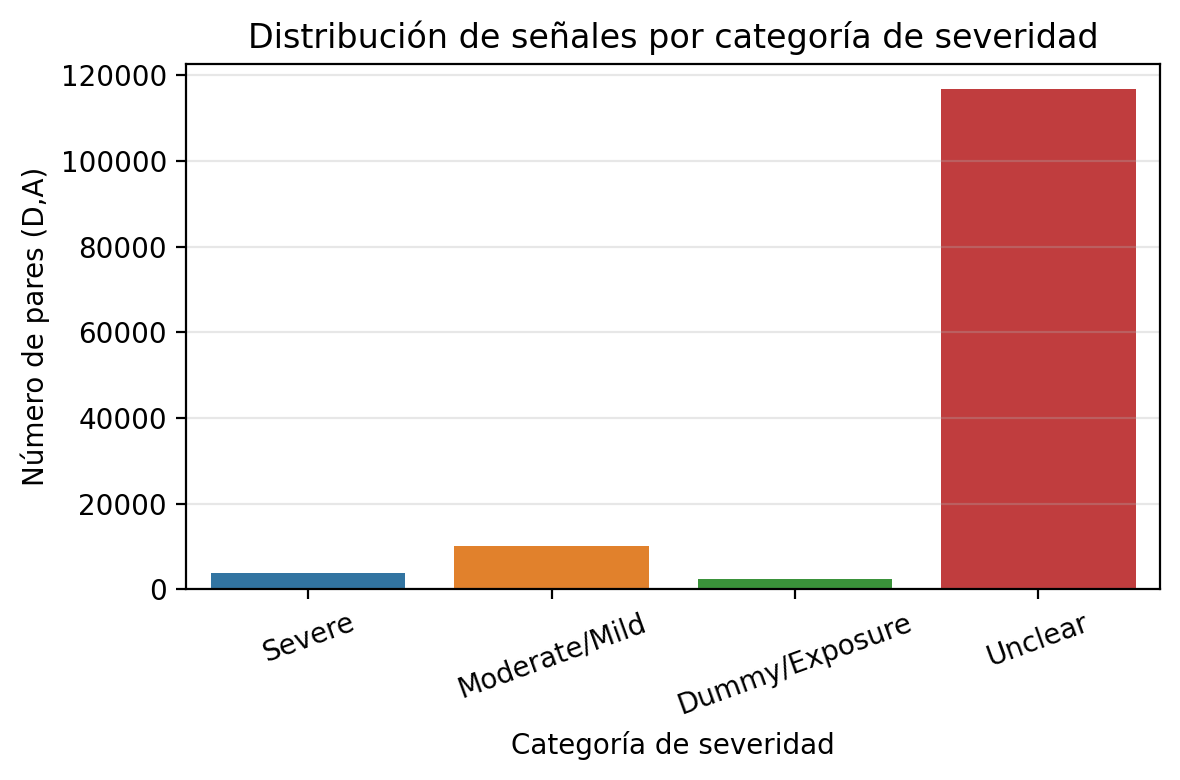

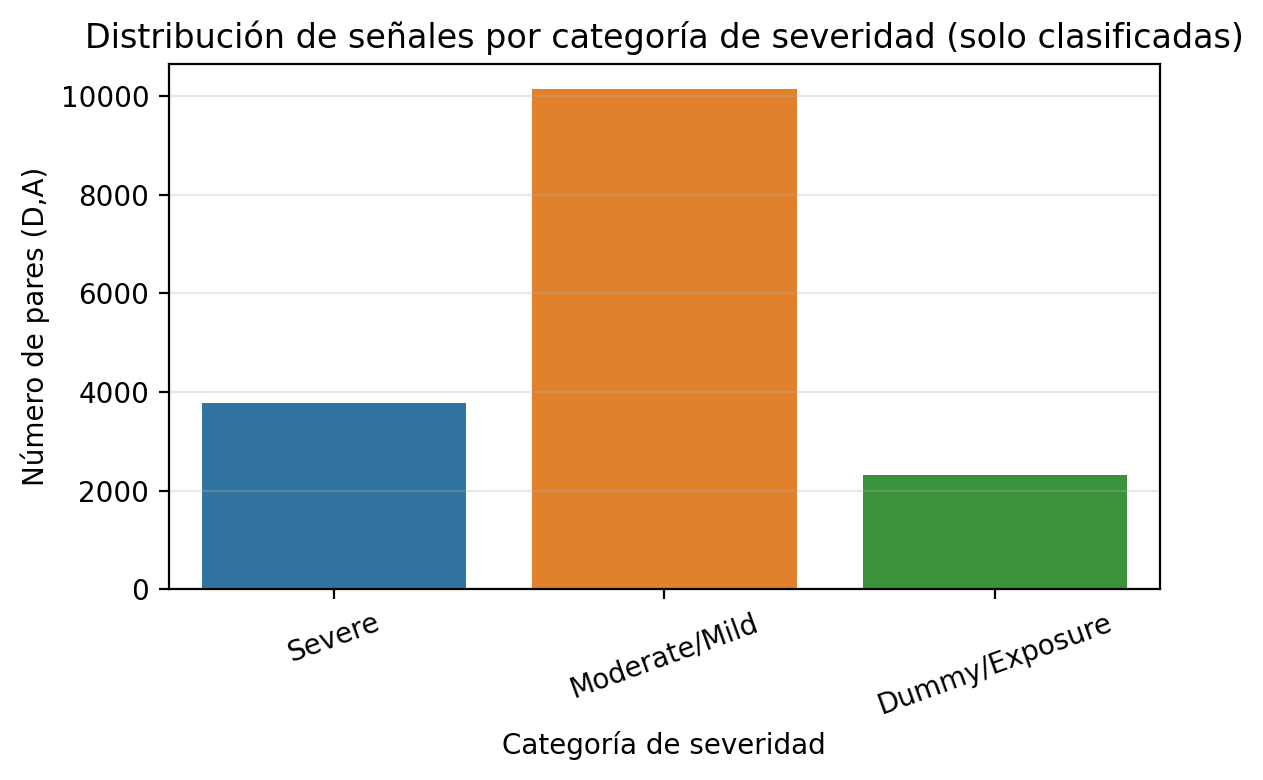

In [93]:
plt.figure(figsize=(6,4),dpi=200)
order = ["Severe", "Moderate/Mild", "Dummy/Exposure", "Unclear"]

sns.countplot(
    data=sig_pos_clin,
    x="severity_category",
    order=order
)
plt.title("Distribución de señales por categoría de severidad")
plt.xlabel("Categoría de severidad")
plt.ylabel("Número de pares (D,A)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.grid(True, axis='y',alpha=0.3)
plt.show()

plt.figure(figsize=(6,4),dpi=200)
order = ["Severe", "Moderate/Mild", "Dummy/Exposure"]

sns.countplot(
    data=sig_pos_clin,
    x="severity_category",
    order=order
)
plt.title("Distribución de señales por categoría de severidad (solo clasificadas)")
plt.xlabel("Categoría de severidad")
plt.ylabel("Número de pares (D,A)")
plt.xticks(rotation=20)
plt.tight_layout()
#plt.ylim([0, 12_000])
plt.grid(True, axis='y',alpha=0.3)
plt.show()

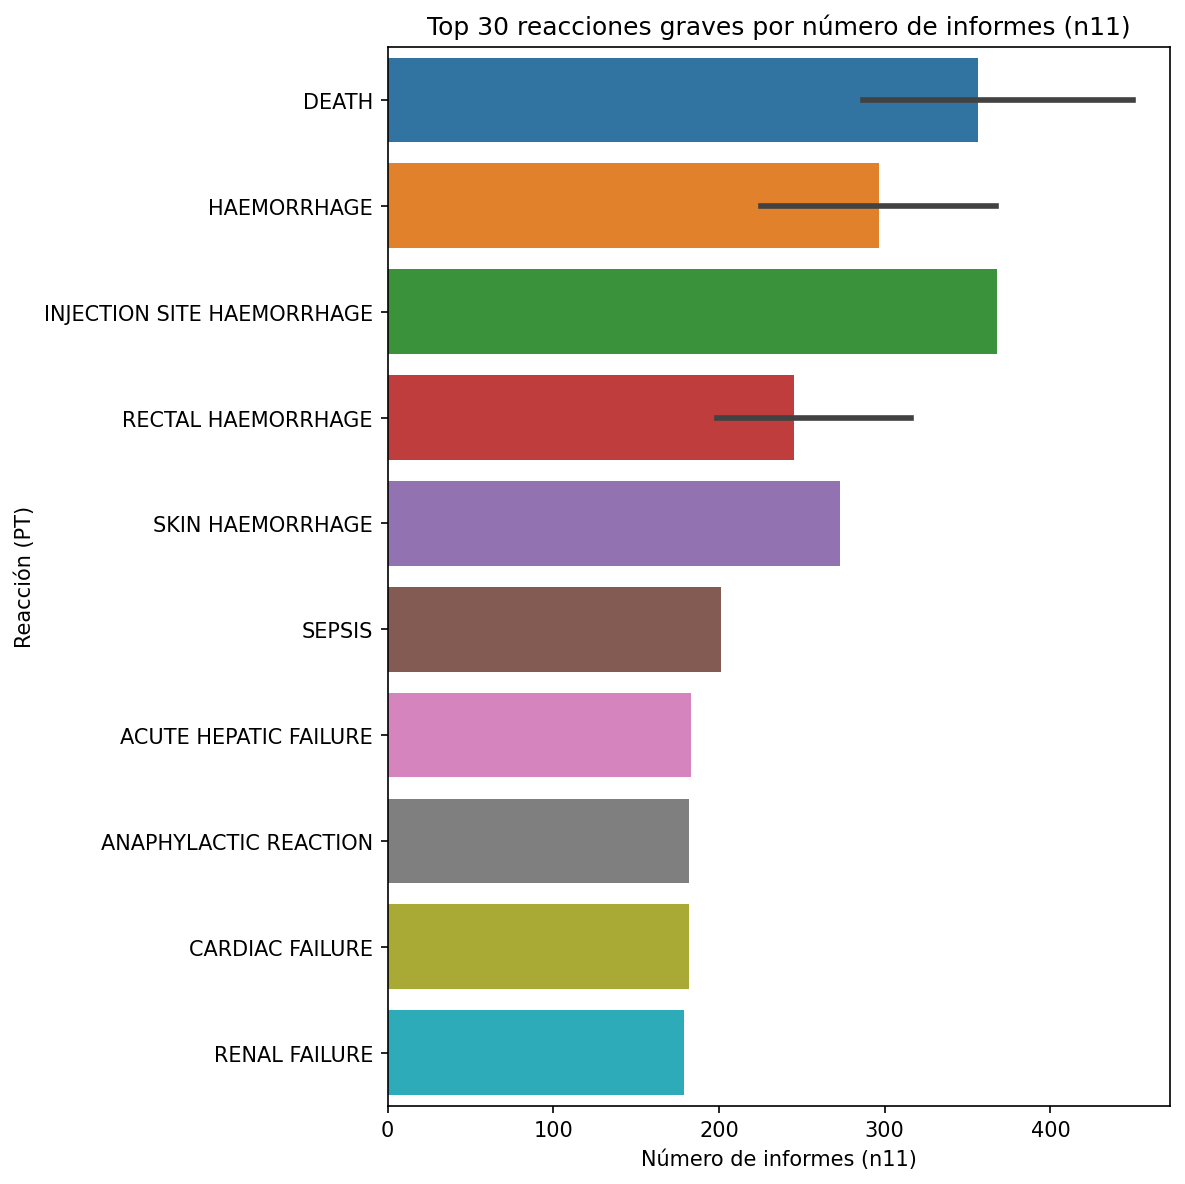

In [95]:
top_severe = (
    sig_pos_clin[sig_pos_clin["severity_category"] == "Severe"]
    .sort_values("n11", ascending=False)
    .head(30)
)

plt.figure(figsize=(8,8),dpi=150)
sns.barplot(
    data=top_severe,
    x="n11",
    y="reaction_pt"
)
plt.title("Top 30 reacciones graves por número de informes (n11)")
plt.xlabel("Número de informes (n11)")
plt.ylabel("Reacción (PT)")
plt.tight_layout()
plt.show()


## Resultados de severidad clínica

La **distribución de señales por categoría de severidad** muestra que la mayoría de los pares fármaco–reacción con señal positiva (IC95% inferior del ROR > 1) se concentran en la categoría **Unclear**, mientras que una fracción menor corresponde a eventos **Moderate/Mild**, **Dummy/Exposure** y, en particular, a eventos **Severe**. Este patrón es esperable en análisis de farmacovigilancia a gran escala, ya que muchas reacciones reportadas en FAERS no pueden clasificarse inequívocamente como graves o leves mediante reglas automáticas basadas en texto y requieren una evaluación clínica más detallada. La categoría **Dummy/Exposure** representa una proporción reducida del total, lo que indica que el filtrado previo de términos administrativos y de exposición fue efectivo para eliminar ruido no clínico.

En contraste, el **Top 30 de reacciones graves por número de informes (n11)** evidencia que las señales clasificadas como **Severe** corresponden a eventos adversos clínicamente bien establecidos y de alto impacto, tales como **muerte**, **hemorragias** (incluyendo localizaciones específicas), **sepsis**, **reacciones anafilácticas** y **fallos orgánicos** (cardíaco, renal y hepático). La alta frecuencia relativa de estos eventos dentro de la categoría Severe respalda la validez de la estrategia de clasificación y confirma que el enfoque de priorización por severidad captura adecuadamente desenlaces clínicos relevantes. En conjunto, estas figuras muestran que, aunque las señales graves representan una proporción pequeña del universo total, su identificación y análisis específico es fundamental para orientar la detección temprana de riesgos de seguridad y para focalizar el análisis posterior en eventos con mayor impacto potencial en la salud del paciente.


## Enfoque del análisis en señales clínicas relevantes

Aunque el análisis inicial identificó un gran número de pares fármaco–reacción con señal estadística positiva (IC95% inferior del ROR > 1), no todas estas asociaciones tienen el mismo significado clínico. Por esta razón, el análisis principal se centra en las categorías **Severe** y **Moderate/Mild**, que corresponden a eventos adversos clínicos reales con impacto potencial en la salud del paciente. Las señales clasificadas como **Severe** incluyen desenlaces graves y clínicamente bien establecidos, como muerte, sepsis, hemorragias mayores y fallos orgánicos, mientras que la categoría **Moderate/Mild** agrupa eventos clínicamente relevantes pero generalmente no catastróficos, que pueden afectar de manera significativa la calidad de vida o representar etapas tempranas de un daño más severo. En contraste, los términos **Dummy/Exposure** describen exposiciones, contextos regulatorios o procesos de monitoreo que no constituyen eventos adversos per se, y la categoría **Unclear** agrupa reacciones que requieren una evaluación clínica más detallada. Al focalizar el análisis en señales Severe y Moderate/Mild, se prioriza la relevancia clínica sobre la magnitud puramente estadística, se reduce el ruido interpretativo y se garantiza que las conclusiones estén directamente vinculadas a riesgos potenciales para el paciente.


In [96]:
# Filtro principal: solo señales clínicas relevantes
main_severity = ["Severe", "Moderate/Mild"]

mask_main = sig_pos_clin["severity_category"].isin(main_severity)
sig_pos_main = sig_pos_clin[mask_main].copy()

sig_pos_main["severity_category"].value_counts()


severity_category
Moderate/Mild    10138
Severe            3778
Name: count, dtype: int64

In [97]:
sig_pos_main.head()

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal,is_dummy_exposure,severity_category
539800,DOLUTEGRAVIR\LAMIVUDINE\TENOFOVIR DISOPROXIL F...,CONGENITAL UMBILICAL HERNIA,14,25,16,390140,11,2,390113,196752.895652,0.745604,45630.014568,8.483824e+05,109232.200000,True,False,Severe
394632,CLOFIBRATE,VAGINAL FLATULENCE,17,19,33,390140,2,16,390105,165499.303030,0.719549,40392.735965,6.780927e+05,21815.976974,True,False,Moderate/Mild
1418544,SODIUM STEARATE,VAGINAL FLATULENCE,14,15,33,390140,1,19,390106,193386.128205,0.887083,33987.933591,1.100337e+06,19164.035088,True,False,Moderate/Mild
274628,CALCITRIOL\CALCIUM CARBONATE\ZINC,VAGINAL FLATULENCE,15,17,33,390140,2,18,390105,130738.059459,0.720120,31873.044983,5.362663e+05,19123.676471,True,False,Moderate/Mild
150331,ASPIRIN\CITRIC ACID MONOHYDRATE\SODIUM BICARBO...,VAGINAL FLATULENCE,13,13,33,390140,0,20,390107,513800.121951,1.457003,29550.742098,8.933467e+06,19506.350000,True,False,Moderate/Mild


El conjunto de datos analíticos principal consta de 13.916 señales clínicamente relevantes (3.778 graves y 10.138 moderadas/leves).

In [98]:
# Los términos de sólo exposición y no clasificados se excluyeron del análisis principal.
sig_excluded = sig_pos_clin[
    ~sig_pos_clin["severity_category"].isin(["Severe", "Moderate/Mild"])
].copy()

sig_excluded["severity_category"].value_counts()


severity_category
Unclear           116709
Dummy/Exposure      2329
Name: count, dtype: int64

## Caracterización global de las señales

In [99]:
sig_pos_main[["n11", "n1dot", "ndot1", "N", "ROR", "ROR_L95", "ROR_U95", "PRR"]].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

,n11,n1dot,ndot1,N,ROR,ROR_L95,ROR_U95,PRR
count,13916.000000,13916.000000,13916.000000,13916.0,13916.000000,13916.000000,1.391600e+04,1.391600e+04
mean,62.766168,1664.316614,6807.244898,390140.0,268.237275,63.821438,2.467641e+03,inf
std,113.347133,2612.830680,5898.604337,0.0,6920.321228,878.186709,1.062428e+05,NaN
min,10.000000,10.000000,12.000000,390140.0,1.155695,1.000061,1.298021e+00,1.148840e+00
50%,25.000000,725.000000,4471.000000,390140.0,4.608772,3.185284,6.848448e+00,4.221498e+00
75%,60.000000,2144.000000,11716.000000,390140.0,13.143582,8.841407,2.014656e+01,1.092741e+01
90%,154.000000,4013.000000,14944.000000,390140.0,61.597840,36.501123,1.021670e+02,4.768112e+01
95%,250.250000,6500.000000,17129.000000,390140.0,183.780301,104.039551,3.254587e+02,1.441568e+02
99%,506.000000,13865.000000,17129.000000,390140.0,1585.813355,737.382879,4.107056e+03,9.953108e+02
max,4916.000000,34807.000000,17129.000000,390140.0,513800.121951,45630.014568,8.933467e+06,inf


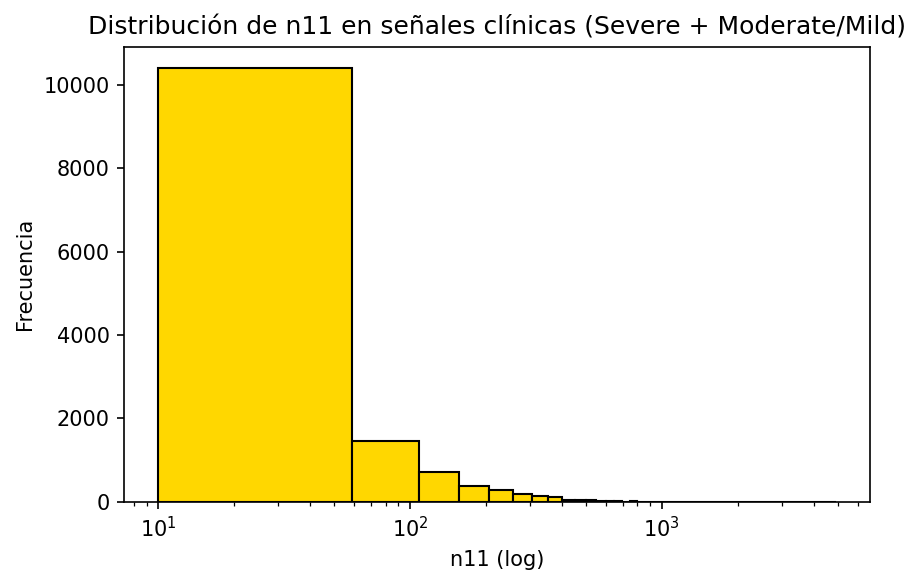

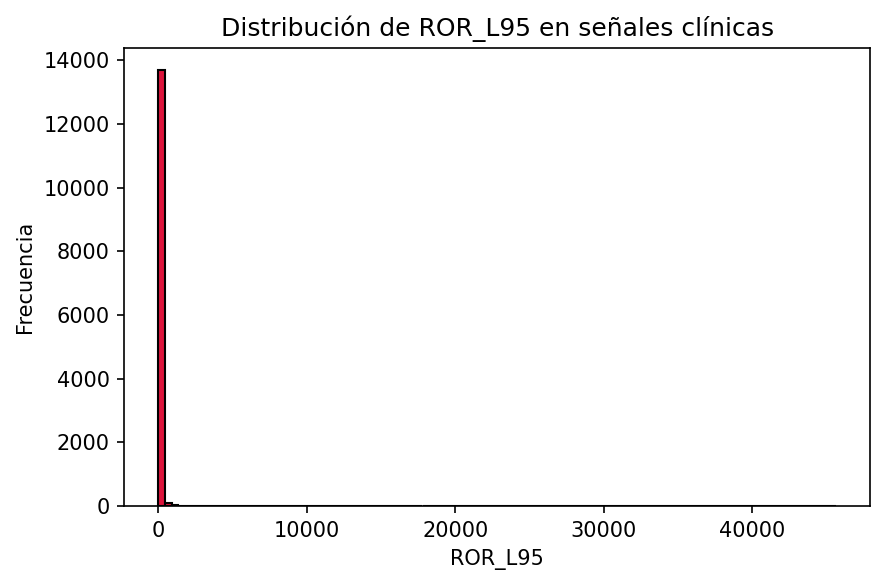

In [114]:
# Distribución de n11 (log-scale)
plt.figure(figsize=(6,4),dpi=150)
plt.hist(sig_pos_main["n11"], bins=100, color='gold',edgecolor='black')
plt.xscale("log")
plt.xlabel("n11 (log)")
plt.ylabel("Frecuencia")
plt.title("Distribución de n11 en señales clínicas (Severe + Moderate/Mild)")
plt.tight_layout()
plt.show()

# Distribución de ROR_L95
plt.figure(figsize=(6,4),dpi=150)
plt.hist(sig_pos_main["ROR_L95"], bins=100, color='crimson',edgecolor='black')
plt.xlabel("ROR_L95")
plt.ylabel("Frecuencia")
#plt.ylim([0, 120])
plt.title("Distribución de ROR_L95 en señales clínicas")
plt.tight_layout()
plt.show()


El conjunto de señales clínicas analizadas estuvo conformado por 13,916 pares fármaco–reacción clasificados como **Severe** o **Moderate/Mild**. La distribución del número de informes asociados a cada señal (`n11`) presentó una marcada asimetría positiva, con una cola larga, característica típica de bases de farmacovigilancia a gran escala. La mediana de `n11` fue de 25 informes, mientras que el 75% de las señales presentó menos de 60 reportes y el 90% menos de 154, lo que indica que la mayoría de las señales clínicas se sustentan en un número moderado de casos, coexistiendo con un subconjunto reducido de señales altamente reportadas. De forma análoga, la distribución del límite inferior del intervalo de confianza del ROR (`ROR_L95`) mostró una alta concentración cercana al umbral de señalización (mediana = 3.19), acompañada de valores extremos que alcanzan órdenes de magnitud elevados. En conjunto, estos resultados evidencian una estructura altamente heterogénea en la fortaleza estadística y el soporte empírico de las señales clínicas, lo que justifica la necesidad de estrategias de priorización basadas simultáneamente en medidas de asociación y severidad clínica.

### Comparación Severe vs Moderate/Mild

In [115]:
sig_pos_main.groupby("severity_category")[["n11", "ROR", "ROR_L95"]].describe()

n11                                                  
                     count       mean         std   min   25%   50%   75%   
severity_category                                                           
Moderate/Mild      10138.0  75.869501  128.691927  10.0  16.0  30.0  82.0  \
Severe              3778.0  27.604288   34.429745  10.0  13.0  18.0  30.0   

                               ROR              ...                             
                      max    count        mean  ...        75%            max   
severity_category                               ...                             
Moderate/Mild      4916.0  10138.0  186.881200  ...   9.821455  513800.121951  \
Severe              914.0   3778.0  486.550638  ...  41.663603  309139.415094   

                   ROR_L95                                               
                     count        mean         std       min       25%   
severity_category                                                        
Moderate/Mild      10138.0   48.852515  850.408535  1.000673  1.772626  \
Severe              3778.0  103.989503  947.667145  1.000061  2.024447   

                                                      
                        50%        75%           max  
severity_category                                     
Moderate/Mild      2.916870   6.736647  40392.735965  
Severe             4.769661  26.118665  45630.014568  

[2 rows x 24 columns]

<Figure size 750x600 with 0 Axes>

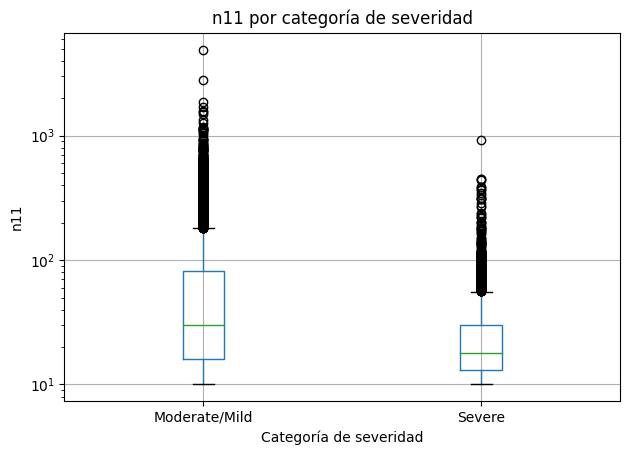

<Figure size 750x600 with 0 Axes>

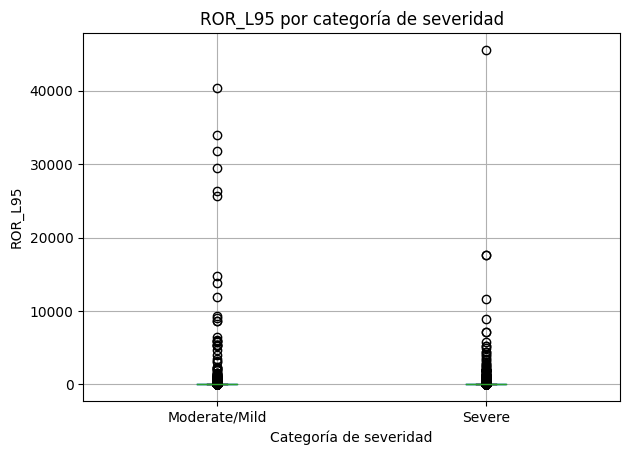

In [116]:
for col in ["n11", "ROR_L95"]:
    plt.figure(figsize=(5,4),dpi=150)
    sig_pos_main.boxplot(column=col, by="severity_category")
    if col == "n11":
        plt.yscale("log")
    plt.title(f"{col} por categoría de severidad")
    plt.suptitle("")
    plt.xlabel("Categoría de severidad")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Al estratificar las señales clínicas por categoría de severidad se observan patrones diferenciados tanto en el soporte (`n11`) como en la magnitud de la asociación (`ROR_L95`). Las señales **Moderate/Mild** son numéricamente dominantes (10,138 pares) y tienden a estar respaldadas por un mayor número de informes: presentan una media de `n11` de 75.9 casos (mediana = 30; rango intercuartílico 16–82) y un máximo de 4,916 reportes, lo que se refleja en una distribución con cola larga hacia valores altos. En contraste, las señales **Severe** (3,778 pares) muestran un soporte más modesto, con una media de `n11` de 27.6 casos (mediana = 18; rango intercuartílico 13–30) y un máximo de 914 informes. Sin embargo, la fuerza de la asociación es sistemáticamente mayor en las señales graves: el límite inferior del IC95% del ROR (`ROR_L95`) presenta una mediana de 4.77 para las señales Severe frente a 2.92 en las Moderate/Mild, con percentiles superiores marcadamente más altos (P75 = 26.1 vs 6.74). Los boxplots evidencian además un conjunto de outliers extremos en ambas categorías, pero con valores de `ROR_L95` más concentrados y elevados en el grupo Severe. En conjunto, estos resultados indican que, aunque las señales moderadas son más frecuentes y cuentan con mayor número de casos, las señales graves tienden a mostrar asociaciones más fuertes entre fármaco y evento, lo que refuerza su prioridad desde el punto de vista de la seguridad clínica.


### Score de prioridad y rankeo dentro de cada categoría

Definimos una puntuación de prioridad heurística como el producto de los logaritmos del límite inferior de confianza del 95% del ROR y el número de informes (log(ROR_L95) × log(n11)), para capturar conjuntamente la solidez y el respaldo empírico de cada señal. Esta formulación penaliza las asociaciones extremadamente sólidas, pero respaldadas por muy pocos casos, así como las asociaciones muy frecuentes con una desproporcionalidad marginal, y destaca las señales estadísticamente sólidas y bien respaldadas.

priority_score = log(ROR_L95) * log(n11)



    log(ROR_L95)

        Si ROR_L95 ≈ 1 → log cercano a 0 → casi no aporta al score.

        Si ROR_L95 es muy grande → log crece, pero no linealmente (suaviza outliers).

    log(n11)

        Si n11 es pequeño (p.ej. 10) → log es modesto.

        Si n11 es grande → crece, pero otra vez de forma suavizada.

    Producto de ambos

        Si una señal tiene ambos grandes (ROR fuerte y muchos casos), el producto es alto.

        Si uno de los dos es pequeño, el producto se cae:

            ROR muy alto pero n11 pequeño → log(n11) pequeño → score moderado.

            n11 enorme pero ROR “tibio” → log(ROR_L95) pequeño → score moderado.

Es decir, el score favorece equilibrio:

    No solo “muy fuerte” ni solo “muy frecuente”, sino fuerte y frecuente.

In [117]:
sig_pos_main["priority_score"] = np.log(sig_pos_main["ROR_L95"]) * np.log(sig_pos_main["n11"])

In [120]:
#guardamos
#sig_pos_main = sig_pos_main.drop(['is_signal','is_dummy_exposure'],axis=1)
#sig_pos_main.to_csv(BASE_ROOT / "sig_pos_severity.csv", index=False)

In [122]:
top_severe = (
    sig_pos_main[sig_pos_main["severity_category"] == "Severe"]
    .sort_values("priority_score", ascending=False)
    .head(50)
)
top_severe[["drug_key", "reaction_pt", "n11", "ROR_L95", "priority_score"]].head(10)


,drug_key,reaction_pt,n11,ROR_L95,priority_score
922295,LEVONORGESTREL,GENITAL HAEMORRHAGE,107,901.678399,31.795133
582190,EMICIZUMAB-KXWH,HAEMORRHAGE,345,161.214712,29.701200
756802,HAIR KERATIN AMINO ACIDS GOLD COMPLEX,CONGENITAL ANOMALY,49,1826.139760,29.227413
747337,GOLD SODIUM THIOMALATE,CONGENITAL ANOMALY,70,857.751321,28.695672
539800,DOLUTEGRAVIR\LAMIVUDINE\TENOFOVIR DISOPROXIL F...,CONGENITAL UMBILICAL HERNIA,14,45630.014568,28.312654
206781,BETA GLUCAN,PULMONARY ALVEOLAR HAEMORRHAGE,28,4404.590081,27.958537
792579,HYDROCORTISONE PROBUTATE,CONGENITAL ANOMALY,43,1221.804751,26.734928
896140,LECANEMAB-IRMB,AMYLOID RELATED IMAGING ABNORMALITY-MICROHAEMO...,53,770.371582,26.390026
896939,LEDIPASVIR,HAEMORRHAGIC STROKE,20,5814.803177,25.967493
635067,ETONOGESTREL,VAGINAL HAEMORRHAGE,114,238.022462,25.918207


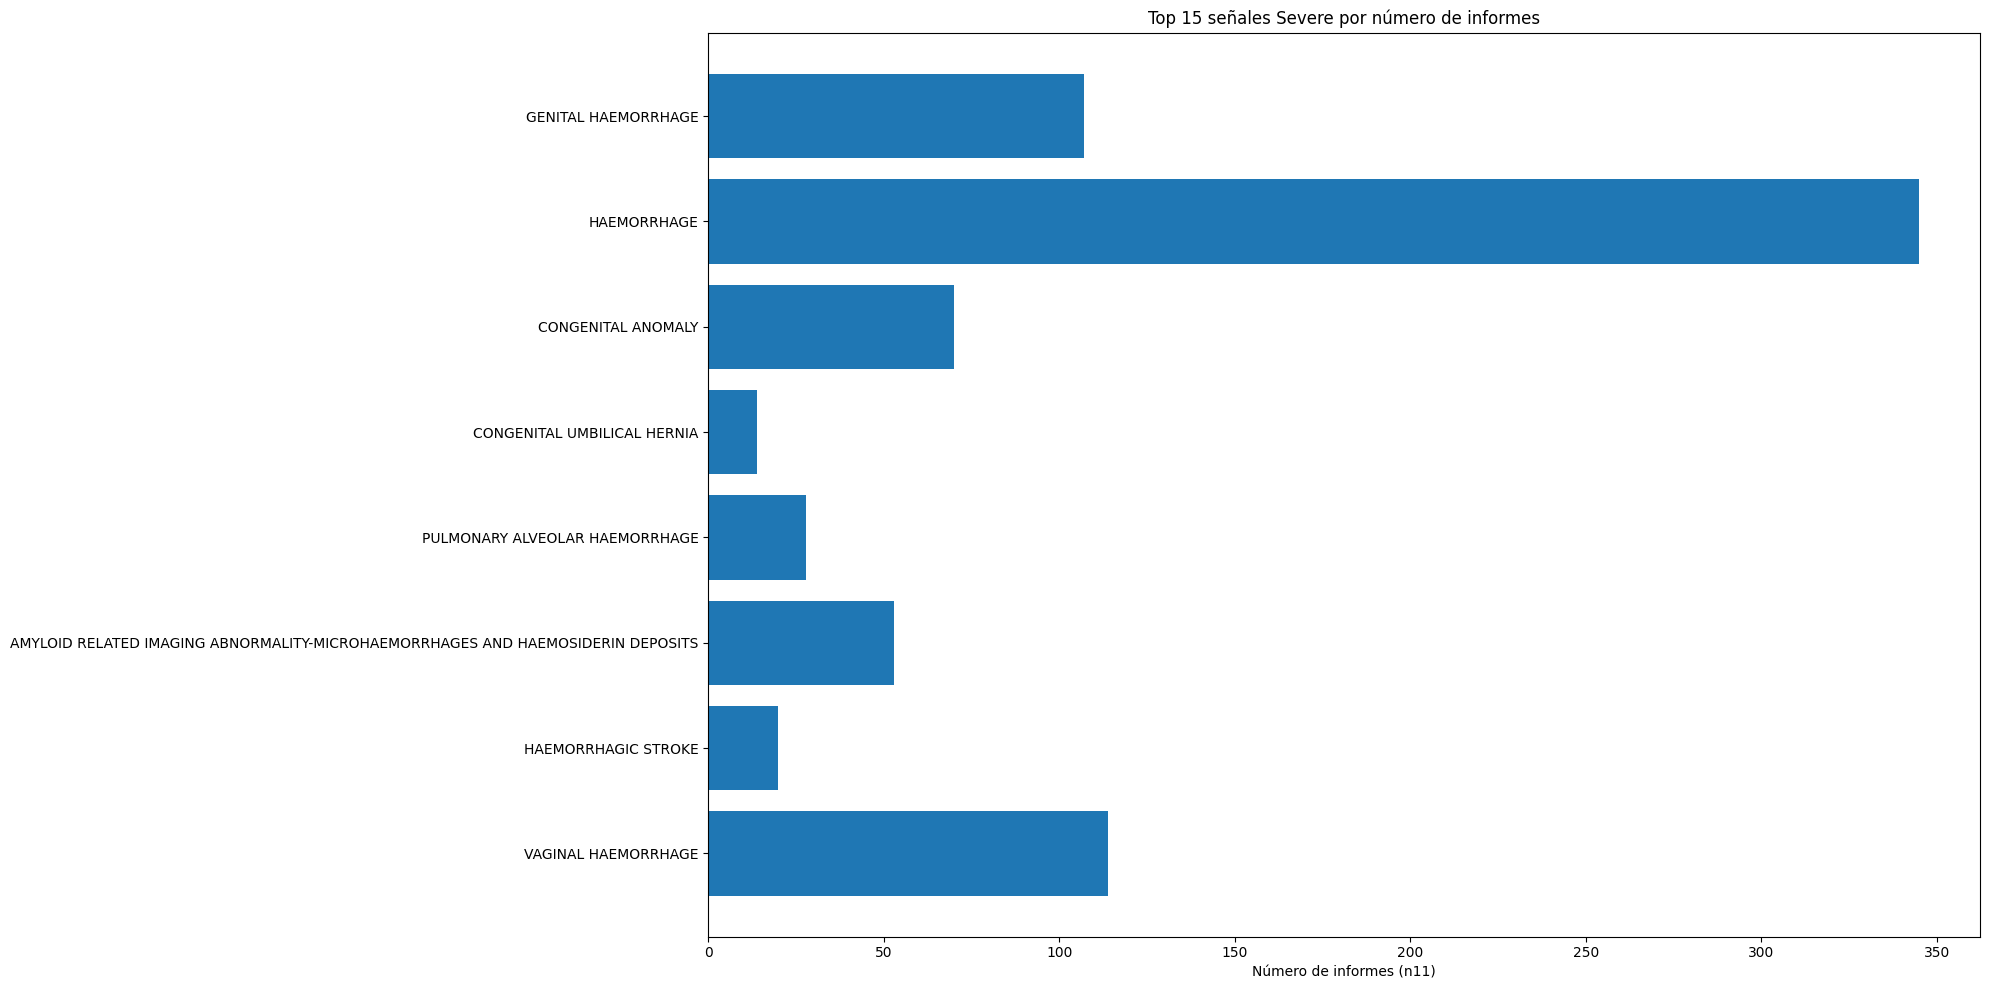

In [124]:
top_severe_plot = top_severe.head(10).copy()

plt.figure(figsize=(20, 10))
plt.barh(top_severe_plot["reaction_pt"], top_severe_plot["n11"])
plt.gca().invert_yaxis()
plt.xlabel("Número de informes (n11)")
plt.title("Top 15 señales Severe por número de informes")

plt.tight_layout()
plt.show()

In [125]:
top_moderate = (
    sig_pos_main[sig_pos_main["severity_category"] == "Moderate/Mild"]
    .sort_values("priority_score", ascending=False)
    .head(50)
)
top_moderate[["drug_key", "reaction_pt", "n11", "ROR_L95", "priority_score"]].head(10)


,drug_key,reaction_pt,n11,ROR_L95,priority_score
477049,DESOXIMETASONE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,207,469.638038,32.806685
1234627,PHTHALYLSULFATHIAZOLE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,187,524.905834,32.763578
353437,CHLORHEXIDINE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,136,637.759043,31.725731
1437330,SULFAMETHOXAZOLE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,145,498.295056,30.911451
475777,DESOGESTREL\ETHINYL ESTRADIOL,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,118,624.251975,30.706770
355409,CHLORHEXIDINE GLUCONATE\ISOPROPYL ALCOHOL,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,139,497.340260,30.639503
394632,CLOFIBRATE,VAGINAL FLATULENCE,17,40392.735965,30.050209
348705,CETIRIZINE HYDROCHLORIDE\PSEUDOEPHEDRINE HYDRO...,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,151,396.861192,30.021328
682147,FLUMETHASONE PIVALATE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,145,411.665662,29.960990
898388,LEFLUNOMIDE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,218,260.017072,29.941816


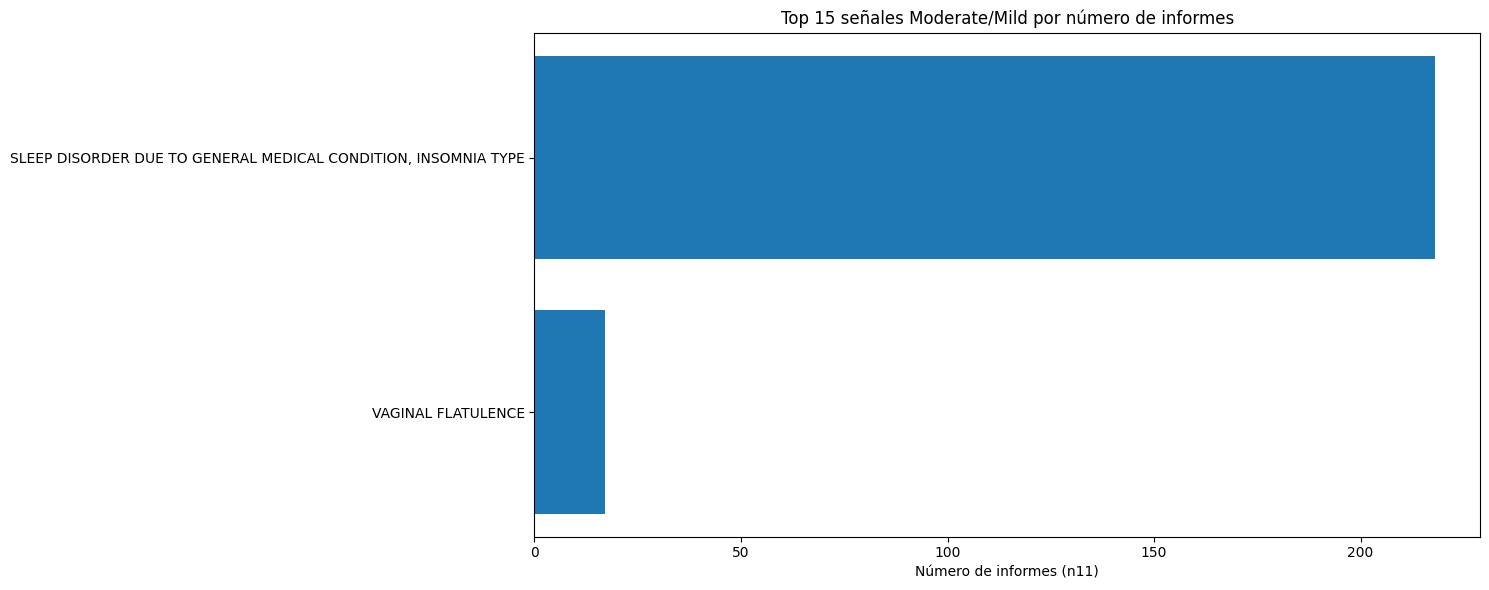

In [126]:
top_moderate_plot = top_moderate.head(10).copy()

plt.figure(figsize=(15, 6))
plt.barh(top_moderate_plot["reaction_pt"], top_moderate_plot["n11"])
plt.gca().invert_yaxis()
plt.xlabel("Número de informes (n11)")
plt.title("Top 15 señales Moderate/Mild por número de informes")


plt.tight_layout()
plt.show()


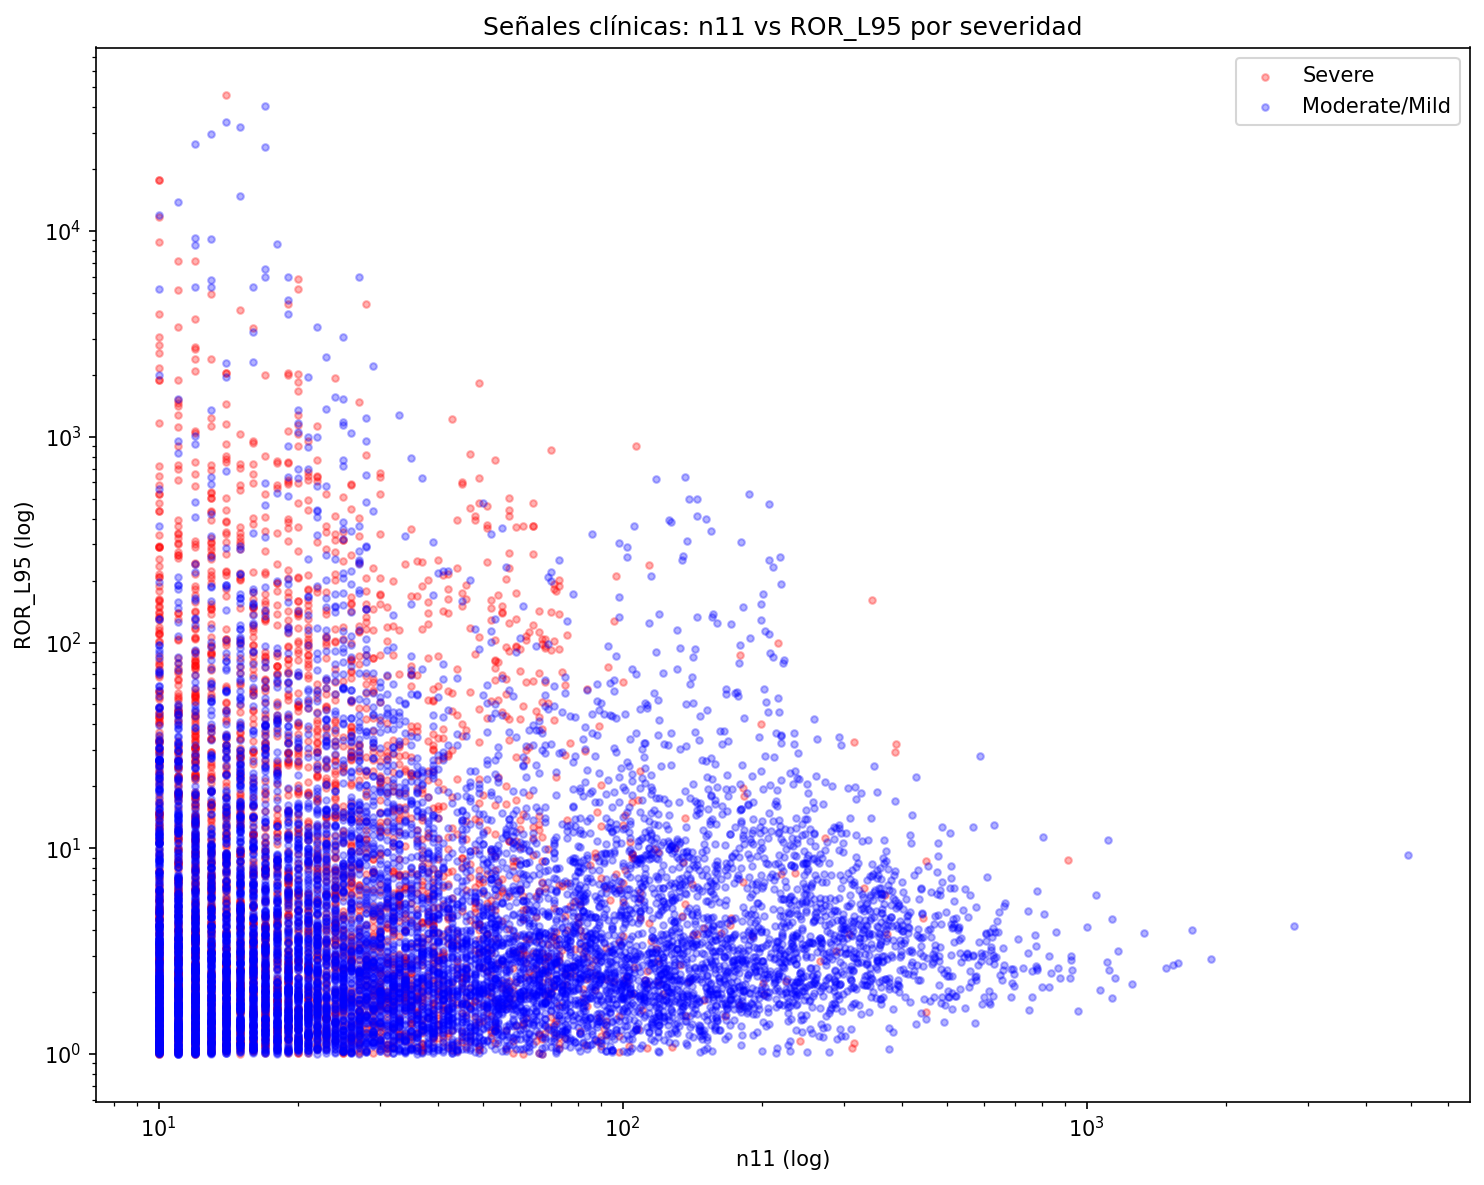

In [128]:
import numpy as np

plt.figure(figsize=(10, 8),dpi=150)
for sev, color in [("Severe", "red"), ("Moderate/Mild", "blue")]:
    sub = sig_pos_main[sig_pos_main["severity_category"] == sev]
    plt.scatter(sub["n11"], sub["ROR_L95"], alpha=0.3, s=10, label=sev, c=color)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("n11 (log)")
plt.ylabel("ROR_L95 (log)")
plt.title("Señales clínicas: n11 vs ROR_L95 por severidad")
plt.legend()
plt.tight_layout()
plt.show()


La Figura muestra la relación entre el número de informes asociados a cada señal (`n11`) y la fuerza de la asociación medida mediante el límite inferior del IC95% del ROR (`ROR_L95`), estratificada por categoría de severidad. Se observa un patrón inverso claro entre ambas magnitudes: las señales con valores extremadamente altos de `ROR_L95` tienden a estar respaldadas por un número reducido de informes, mientras que aquellas con mayor soporte (`n11` elevado) presentan, en general, valores más moderados de `ROR_L95`. Este comportamiento es consistente con la naturaleza de los sistemas de farmacovigilancia, donde asociaciones muy específicas o raras generan razones de reporte elevadas con pocos casos. Al comparar categorías, las señales **Severe** (rojo) se concentran preferentemente en la región de asociaciones más fuertes (`ROR_L95` altos) incluso con soportes modestos, mientras que las señales **Moderate/Mild** (azul) dominan el espacio de mayor `n11`, reflejando eventos más frecuentes pero con asociaciones menos extremas. La superposición parcial entre ambas categorías indica que la severidad clínica no depende exclusivamente del soporte empírico o de la magnitud estadística, sino de la combinación de ambos factores, lo que justifica el uso de métricas de priorización integradas.


El ranking basado en el `priority_score` (combinando `n11` y `ROR_L95`) permitió identificar las señales clínicas más relevantes dentro de cada categoría de severidad. Entre las señales **Severe**, predominan las asociadas a **hemorragias** y **anomalias congénitas**, así como eventos cardiovasculares graves. Por ejemplo, levonorgestrel y distintos preparados hormonales se asociaron a hemorragias genitales y vaginales con límites inferiores de ROR superiores a 200 (p.ej., `ROR_L95` = 901.7 para genital haemorrhage), mientras que varios fármacos inmunológicos y antineoplásicos (como emicizumab-kxwh, donanemab y lecanemab) mostraron señales robustas de haemorrhage, haemorrhagic stroke y amyloid-related imaging abnormalities con `ROR_L95` en el rango de 160–770. Destacan también asociaciones muy marcadas entre combinaciones antirretrovirales y **congenital umbilical hernia** (`ROR_L95` ≈ 45,630), así como entre distintos principios activos (corticoides tópicos, antiinfecciosos y suplementos) y el término general de **congenital anomaly**, con `ROR_L95` de varios cientos. En el grupo **Moderate/Mild**, las señales de mayor prioridad se concentran en dos patrones: por un lado, una serie consistente de fármacos de uso tópico, inmunomoduladores y biológicos (p. ej., desoximetasone, sulfasalazine, etanercept, infliximab, tocilizumab) asociados a **sleep disorder due to general medical condition**, con `n11` elevados (≥100 casos) y `ROR_L95` típicamente entre 150 y 600; por otro, múltiples productos (incluyendo laxantes, suplementos, soluciones tópicas y combinaciones analgésicas) vinculados a **vaginal flatulence**, con soportes más modestos en términos de `n11` pero `ROR_L95` extremadamente altos (a menudo >10,000), lo que sugiere asociaciones muy específicas aunque potencialmente influidas por patrones de uso o de notificación. En conjunto, estos resultados muestran que el ranking por prioridad recupera tanto eventos graves clásicos de farmacovigilancia (hemorragias, anomalías congénitas, arritmias ventriculares, sepsis estreptocócica) como eventos moderados pero muy sobrerrepresentados (trastornos del sueño y síntomas ginecológicos), proporcionando un mapa claro de las señales que requieren revisión clínica detallada.


### Perfil por fármaco

In [129]:
drug_summary = (
    sig_pos_main
    .groupby(["drug_key", "severity_category"])
    .agg(n_signals=("reaction_pt", "nunique"))
    .reset_index()
)

drug_total = (
    drug_summary
    .groupby("drug_key")["n_signals"].sum()
    .rename("total_signals")
    .reset_index()
)

drug_severe = (
    drug_summary[drug_summary["severity_category"]=="Severe"]
    .rename(columns={"n_signals": "severe_signals"})[["drug_key", "severe_signals"]]
)

drug_profile = (
    drug_total.merge(drug_severe, on="drug_key", how="left")
)

drug_profile["severe_signals"] = drug_profile["severe_signals"].fillna(0)
drug_profile["severe_ratio"] = drug_profile["severe_signals"] / drug_profile["total_signals"]


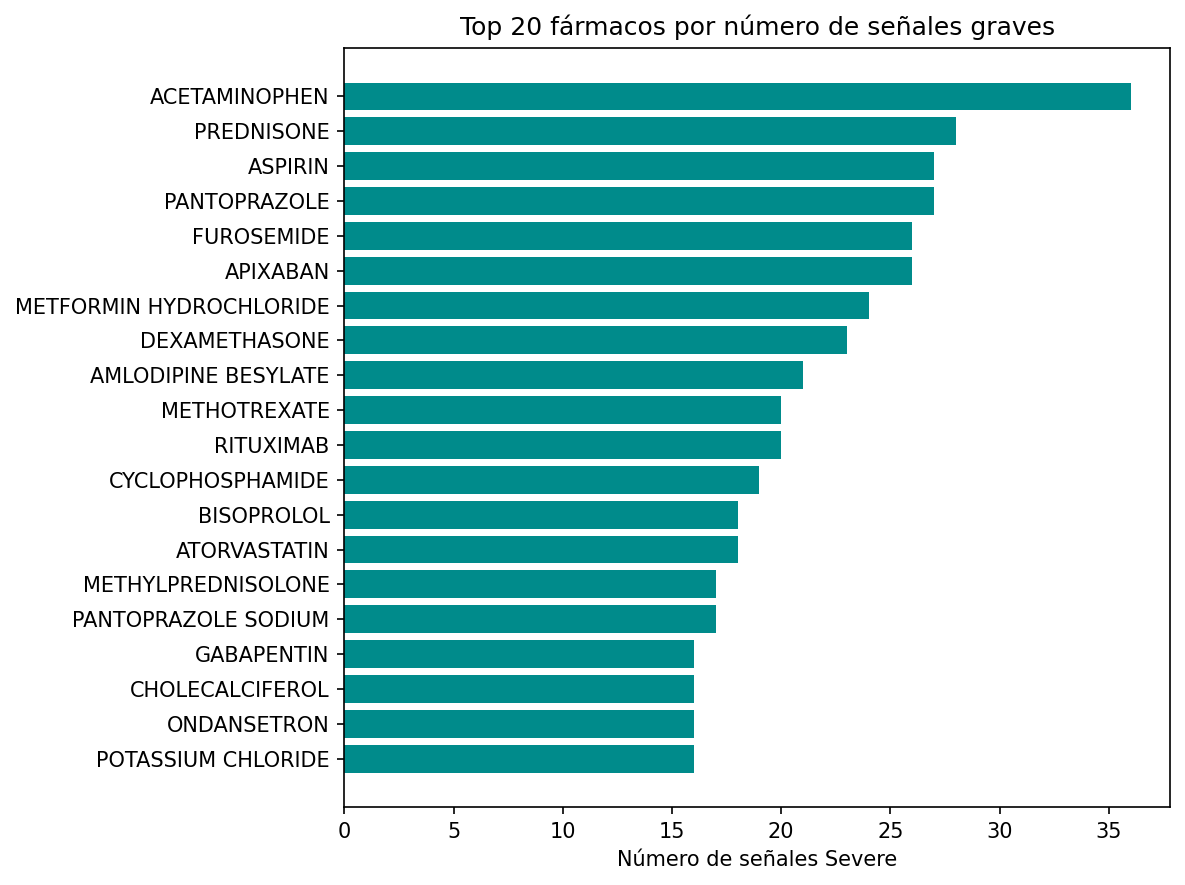

In [130]:
top_drugs_severe = (
    drug_profile.sort_values("severe_signals", ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 6),dpi=150)
plt.barh(top_drugs_severe["drug_key"], top_drugs_severe["severe_signals"],color= 'darkcyan')
plt.gca().invert_yaxis()
plt.xlabel("Número de señales Severe")
plt.title("Top 20 fármacos por número de señales graves")
plt.tight_layout()
plt.show()


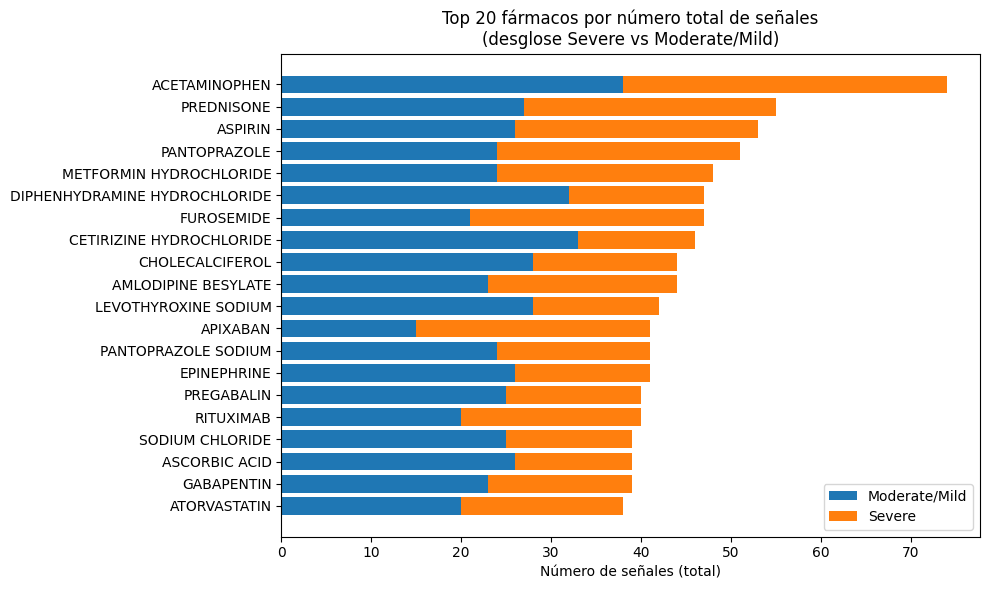

In [131]:
# Necesitamos separar total_señales en Severe y Moderate/Mild
drug_sev_long = (
    sig_pos_main
    .groupby(["drug_key", "severity_category"])
    .agg(n_signals=("reaction_pt", "nunique"))
    .reset_index()
)

# Selecciona fármacos con más señales totales
top_total_drugs = (
    drug_profile.sort_values("total_signals", ascending=False)
    .head(20)["drug_key"]
)

plot_data = (
    drug_sev_long[drug_sev_long["drug_key"].isin(top_total_drugs)]
    .pivot(index="drug_key", columns="severity_category", values="n_signals")
    .fillna(0)
    .loc[top_total_drugs]   # para respetar el orden
)

plt.figure(figsize=(10, 6))
bottom = plot_data["Moderate/Mild"]
plt.barh(plot_data.index, bottom, label="Moderate/Mild")
plt.barh(plot_data.index, plot_data["Severe"], left=bottom, label="Severe")
plt.gca().invert_yaxis()
plt.xlabel("Número de señales (total)")
plt.title("Top 20 fármacos por número total de señales\n(desglose Severe vs Moderate/Mild)")
plt.legend()
plt.tight_layout()
plt.show()


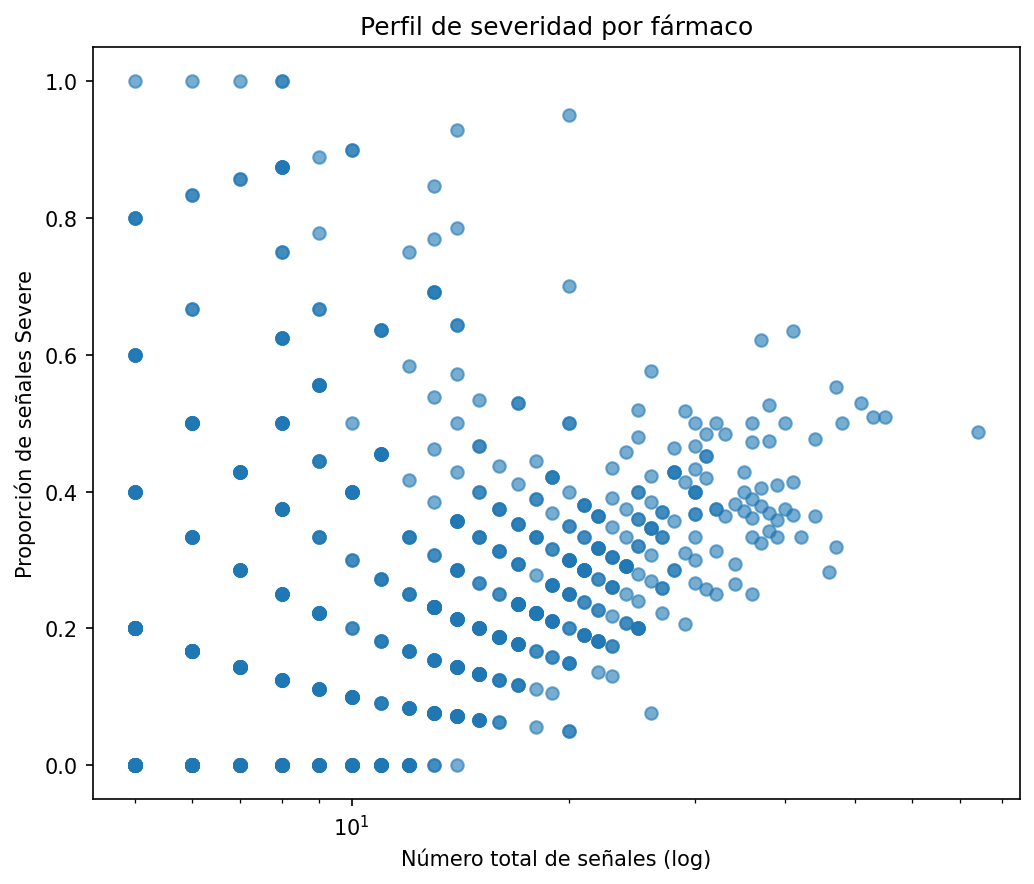

In [132]:
# Opcional: filtrar a fármacos con al menos X señales para evitar ruido
df_scatter = drug_profile[drug_profile["total_signals"] >= 5].copy()

plt.figure(figsize=(7, 6),dpi=150)
plt.scatter(df_scatter["total_signals"], df_scatter["severe_ratio"], alpha=0.6)
plt.xscale("log")
plt.xlabel("Número total de señales (log)")
plt.ylabel("Proporción de señales Severe")
plt.title("Perfil de severidad por fármaco")
plt.tight_layout()
plt.show()


In [133]:
candidatos = df_scatter[
    (df_scatter["total_signals"] >= 50) & (df_scatter["severe_ratio"] >= 0.5)
].sort_values("severe_ratio", ascending=False)

candidatos


,drug_key,total_signals,severe_signals,severe_ratio
1174,PANTOPRAZOLE,51,27.0,0.529412
138,ASPIRIN,53,27.0,0.509434
1269,PREDNISONE,55,28.0,0.509091


Con base en el análisis por fármaco, definimos un subconjunto de
**fármacos candidatos** caracterizados por combinar (i) una carga mínima
de señales clínicas, que garantiza estabilidad estadística, y (ii) una
proporción elevada de eventos clasificados como `Severe` respecto al
total de señales del fármaco. En la práctica, los candidatos se
identifican como aquellos fármacos con un número suficiente de señales
totales y una razón de eventos graves cercana o superior al 50%.
Ejemplos representativos incluyen `PANTOPRAZOLE`, `ASPIRIN` y
`PREDNISONE`, que presentan simultáneamente una alta exposición en la
base de datos y una fracción considerable de desenlaces graves. Es
importante subrayar que esta categorización **no implica causalidad**,
sino que constituye un criterio de **priorización**: los candidatos
señalan asociaciones fármaco–evento que, por su frecuencia y severidad,
merecen análisis más detallados mediante estratificación por indicación,
ajuste por comorbilidades y, eventualmente, evaluación clínica experta.


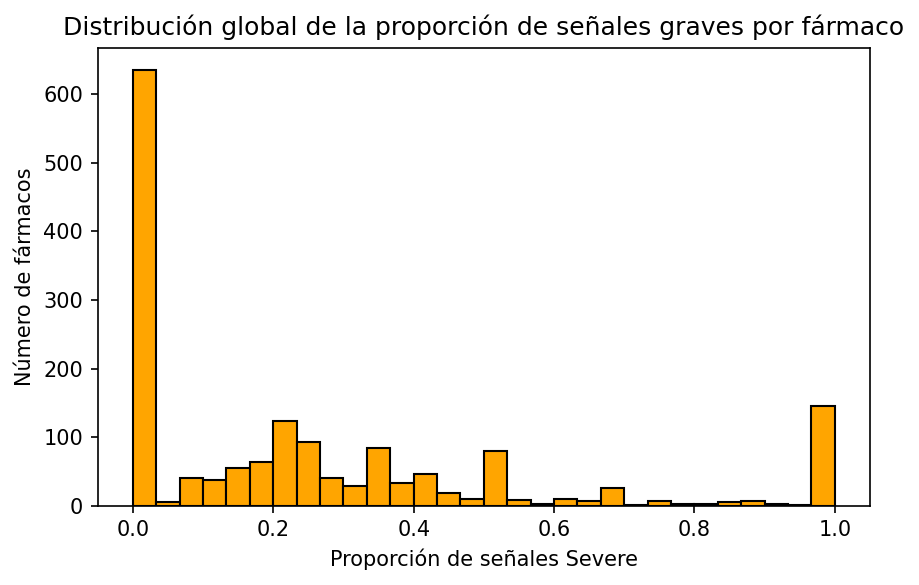

In [134]:
plt.figure(figsize=(6,4),dpi=150)
plt.hist(drug_profile["severe_ratio"], bins=30, edgecolor='black',color ='orange')
plt.xlabel("Proporción de señales Severe")
plt.ylabel("Número de fármacos")
plt.title("Distribución global de la proporción de señales graves por fármaco")
plt.tight_layout()
plt.show()


El análisis a nivel de fármaco revela una marcada heterogeneidad tanto en la carga total de señales clínicas como en la proporción de eventos graves asociados a cada principio activo. Al considerar el número absoluto de señales **Severe**, fármacos de uso amplio y prolongado como acetaminophen, prednisone y aspirin encabezan el ranking, seguidos por agentes de distintas clases terapéuticas, incluyendo inhibidores de la bomba de protones (pantoprazole), diuréticos (furosemide), anticoagulantes (apixaban) y antidiabéticos (metformin). No obstante, el desglose de señales **Severe** frente a **Moderate/Mild** muestra que una alta carga total de señales no implica necesariamente un perfil predominantemente grave: varios fármacos con numerosos reportes presentan una proporción sustancial de eventos moderados, reflejando su uso extendido en la práctica clínica. El análisis de la proporción de señales graves (`severe_ratio`) evidencia que la mayoría de los fármacos se concentra en valores bajos a intermedios (≈0.1–0.4), mientras que solo un subconjunto reducido presenta perfiles dominados por eventos graves. En este contexto, pantoprazole, aspirin y prednisone destacan como candidatos prioritarios, al combinar un número elevado de señales totales con una proporción de señales Severe superior al 50%, lo que los sitúa en la región de mayor interés clínico del espacio de análisis. En conjunto, estos resultados subrayan la importancia de evaluar simultáneamente la frecuencia absoluta de las señales y su severidad relativa, ya que ambas dimensiones aportan información complementaria para la priorización de fármacos en estudios de farmacovigilancia.


## Perfil por fármaco

In [135]:
reaction_sev = (
    sig_pos_main
    .groupby(["reaction_pt", "severity_category"])
    .agg(
        n_drugs=("drug_key", "nunique"),
        n_pairs=("drug_key", "size"),
        total_n11=("n11", "sum")
    )
    .reset_index()
)
reaction_sev.head()


,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
0,ACUTE HEPATIC FAILURE,Severe,13,13,352
1,ACUTE MYOCARDIAL INFARCTION,Severe,29,29,530
2,ACUTE RESPIRATORY FAILURE,Severe,85,85,1490
3,AMYLOID RELATED IMAGING ABNORMALITY-MICROHAEMO...,Severe,2,2,98
4,ANAL HAEMORRHAGE,Severe,3,3,66


In [136]:
top_severe_reactions = (
    reaction_sev[reaction_sev["severity_category"] == "Severe"]
    .sort_values("n_drugs", ascending=False)
)
top_severe_reactions

,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
110,SEPSIS,Severe,394,394,11478
105,RECTAL HAEMORRHAGE,Severe,320,320,11170
31,DEATH,Severe,284,284,15714
13,CARDIAC FAILURE,Severe,168,168,4226
107,RESPIRATORY FAILURE,Severe,145,145,3500
...,...,...,...,...,...
109,SARCOMATOID MESOTHELIOMA,Severe,1,1,12
28,CONGENITAL UMBILICAL HERNIA,Severe,1,1,14
34,DEVICE RELATED SEPSIS,Severe,1,1,17
52,GENITAL HAEMORRHAGE,Severe,1,1,107


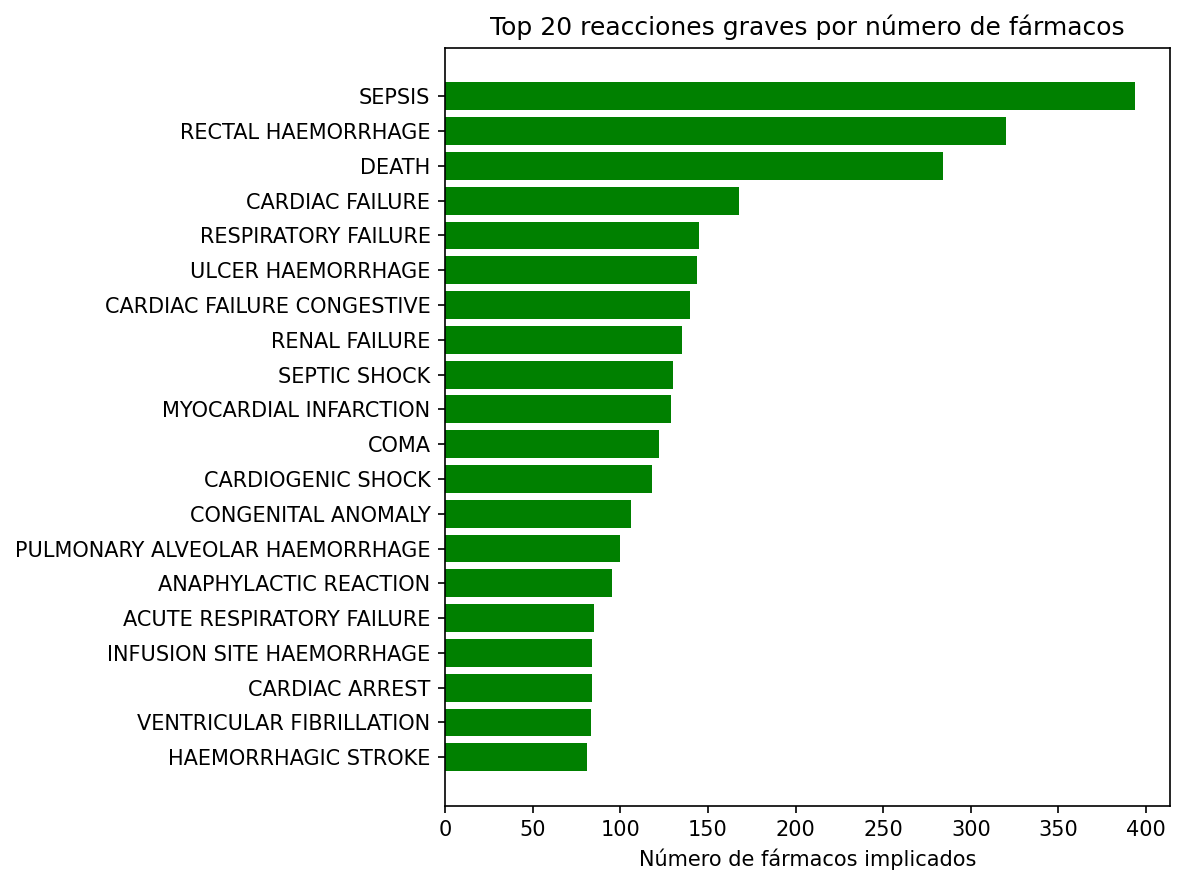

In [137]:
top_severe_reactions_drugs = (
    reaction_sev[reaction_sev["severity_category"] == "Severe"]
    .sort_values("n_drugs", ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 6),dpi=150)
plt.barh(top_severe_reactions_drugs["reaction_pt"],
         top_severe_reactions_drugs["n_drugs"],color='green')
plt.gca().invert_yaxis()
plt.xlabel("Número de fármacos implicados")
plt.title("Top 20 reacciones graves por número de fármacos")
plt.tight_layout()
plt.show()


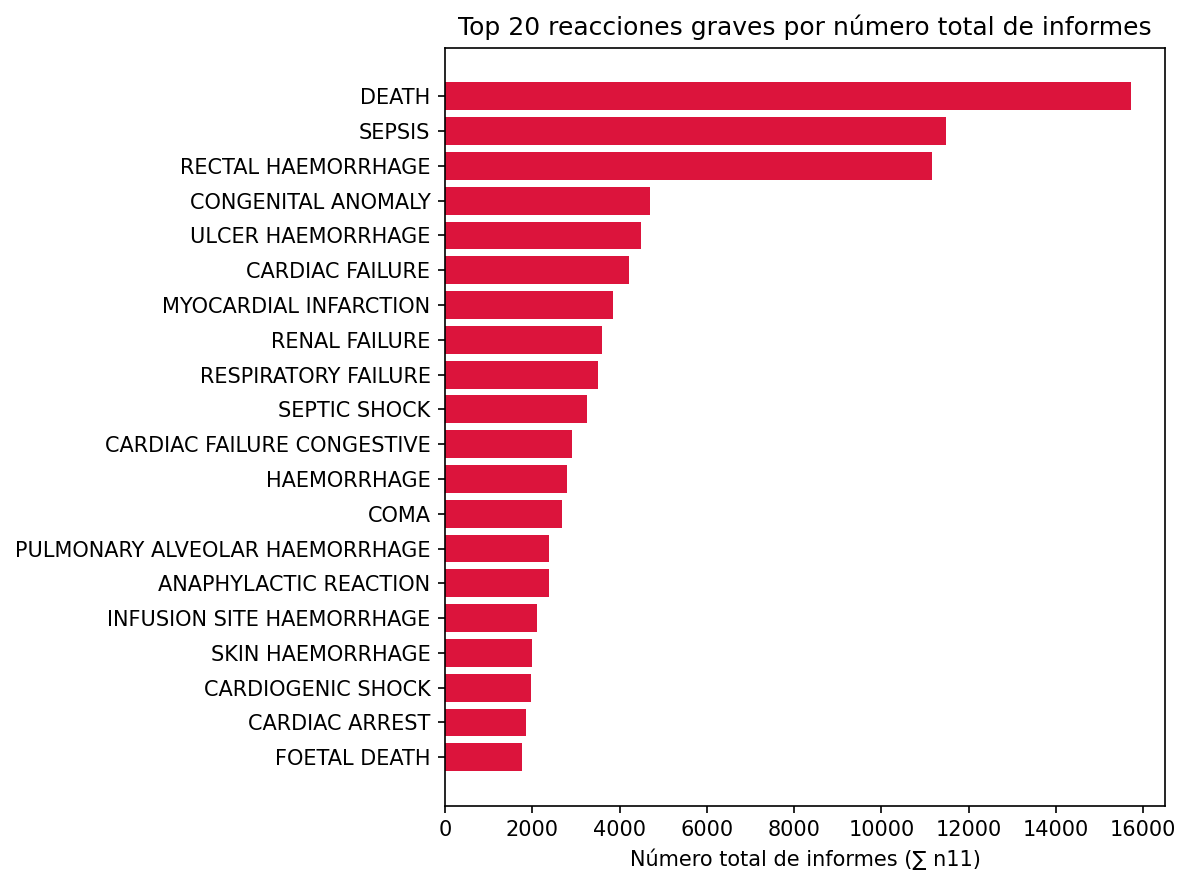

In [138]:
top_severe_reactions_n11 = (
    reaction_sev[reaction_sev["severity_category"] == "Severe"]
    .sort_values("total_n11", ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 6),dpi=150)
plt.barh(top_severe_reactions_n11["reaction_pt"],
         top_severe_reactions_n11["total_n11"],color='crimson')
plt.gca().invert_yaxis()
plt.xlabel("Número total de informes (∑ n11)")
plt.title("Top 20 reacciones graves por número total de informes")
plt.tight_layout()
plt.show()


In [139]:
# Reacciones con muchos pares (independientemente de severidad)
common_reactions = (
    reaction_sev
    .groupby("reaction_pt")["n_pairs"].sum()
    .reset_index()
)
common_reactions = common_reactions[common_reactions["n_pairs"] >= 50]

# Filtra reaction_sev a esas reacciones
reac_long = reaction_sev[
    reaction_sev["reaction_pt"].isin(common_reactions["reaction_pt"])
].copy()

pivot_reac = (
    reac_long
    .pivot(index="reaction_pt", columns="severity_category", values="n_pairs")
    .fillna(0)
)

pivot_reac["total_pairs"] = pivot_reac.sum(axis=1)
pivot_reac["severe_ratio"] = pivot_reac["Severe"] / pivot_reac["total_pairs"]


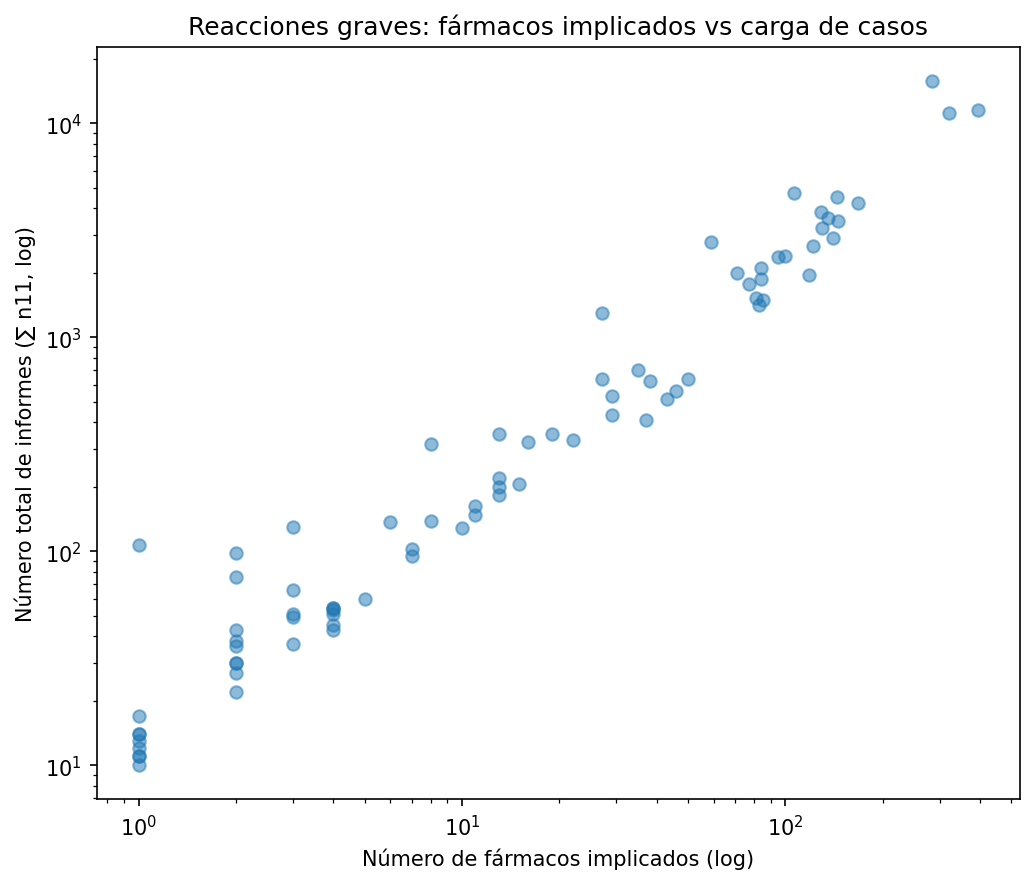

In [140]:
sev_reac = reaction_sev[reaction_sev["severity_category"] == "Severe"].copy()

plt.figure(figsize=(7, 6),dpi=150)
plt.scatter(sev_reac["n_drugs"], sev_reac["total_n11"], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Número de fármacos implicados (log)")
plt.ylabel("Número total de informes (∑ n11, log)")
plt.title("Reacciones graves: fármacos implicados vs carga de casos")
plt.tight_layout()
plt.show()


In [141]:
hot_reac = sev_reac[
    (sev_reac["n_drugs"] >= 5) & (sev_reac["total_n11"] >= 200)
].sort_values("total_n11", ascending=False)
hot_reac

,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
31,DEATH,Severe,284,284,15714
110,SEPSIS,Severe,394,394,11478
105,RECTAL HAEMORRHAGE,Severe,320,320,11170
25,CONGENITAL ANOMALY,Severe,106,106,4708
126,ULCER HAEMORRHAGE,Severe,144,144,4496
13,CARDIAC FAILURE,Severe,168,168,4226
83,MYOCARDIAL INFARCTION,Severe,129,129,3858
106,RENAL FAILURE,Severe,135,135,3594
107,RESPIRATORY FAILURE,Severe,145,145,3500
111,SEPTIC SHOCK,Severe,130,130,3246


El análisis agregado por reacción muestra que un conjunto relativamente acotado de eventos clínicos concentra la mayor parte de la carga de casos y aparece asociado a numerosos fármacos distintos. Entre las reacciones **Severe**, términos como *death*, *sepsis* y *rectal haemorrhage* encabezan el ranking tanto por número total de informes (∑ n11) como por número de fármacos implicados, seguidos de eventos cardiovasculares y respiratorios mayores (*cardiac failure*, *myocardial infarction*, *respiratory failure*, *cardiogenic shock*), insuficiencia orgánica (*renal failure*, *hepatic failure*) y distintos tipos de hemorragia (*ulcer haemorrhage*, *pulmonary alveolar haemorrhage*, *haemorrhagic stroke*). El diagrama de dispersión log–log entre el número de fármacos y la carga total de casos revela una relación aproximadamente creciente: las reacciones que afectan a más fármacos tienden también a acumular más informes, lo que sugiere que se trata de síndromes graves y relativamente “transversales” en la farmacoterapia. Al restringirnos a reacciones frecuentes, la proporción de señales clasificadas como Severe es cercana a 1 para la mayoría de estos términos (por ejemplo, *acute respiratory failure*, *foetal death*, *anaphylactic reaction*, *ventricular fibrillation*), lo que indica que, cuando estas reacciones aparecen en FAERS, casi siempre se reportan en un contexto de alta gravedad clínica. En conjunto, estos resultados identifican un núcleo de eventos críticos que combinan alta severidad, amplia distribución entre fármacos y gran número de casos, constituyendo objetivos prioritarios para una evaluación clínica detallada y para estudios posteriores de causalidad.


# Conclusiones

En este estudio se presentó un enfoque exploratorio para la detección y
priorización de señales de farmacovigilancia basado en la integración de
métricas de desproporcionalidad y criterios de severidad clínica. A partir
de un amplio conjunto de asociaciones fármaco–evento con señal
estadística positiva, se aplicó un proceso sistemático de filtrado para
excluir términos administrativos y de exposición, seguido de una
estratificación por severidad que permitió concentrar el análisis en
eventos clínicamente interpretables. Los resultados muestran una marcada
heterogeneidad en la distribución de las señales, tanto en su soporte
empírico como en la fuerza de asociación, y evidencian que las señales
graves, aunque menos frecuentes, tienden a presentar asociaciones más
robustas. El análisis por fármaco y por reacción identificó un núcleo
reducido de eventos y principios activos que combinan alta carga de
reportes y una proporción elevada de desenlaces severos, definidos aquí
como candidatos prioritarios para evaluación posterior. En conjunto,
este trabajo ilustra cómo la severidad clínica puede utilizarse como un
criterio informativo para la priorización de señales en farmacovigilancia,
sin asumir causalidad directa, y sienta las bases para análisis futuros
más detallados que incorporen estratificación clínica, ajuste por factores
de confusión y revisión experta.
